In [1]:
import sys
sys.path.append('..')

import os
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import gaussian, threshold_otsu
from skimage.transform import resize
from skimage import io
import pickle
from skimage.measure import regionprops

import matplotlib.pyplot as plt
import torch
import time
import model.model_cnnvae_conditional
import model.optimizer as optimizer
from sklearn.decomposition import PCA
import pandas as pd
import torchvision

In [2]:
prevSampled=0
nSamples=36
nProt=6
holdOutSamples_samples=[['HV1','P22','P14','P27'],['HV3','P46','P24','P37'],['HV5','P68','P44','P42'],['HV7','P15','P55','P59'],['HV8','P47','P63','P70'],['HV2','P57','P72','P83']]

In [3]:
sourceDir='/data/xinyi/c2p/data/chromark'
segDir=os.path.join(sourceDir,'nuclear_masks')
imgDir=os.path.join(sourceDir,'raw_data')
conditions=['controls','headneck','meningioma', 'glioma']

outSize=128
savename='pathCentered_'+str(outSize)


In [5]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [6]:
seed=3
epochs=5001
saveFreq=50
lr=0.0001
weight_decay=0 #Weight for L2 loss on embedding matrix.

batchsize=256

In [7]:
def train(epoch,model_clf,optimizer_clf,inputImgs,inputImgs_val,labels_train,labels_val):
    np.random.seed(3)
    train_nodes_idx=np.arange(labels_train.size()[0])
    val_nodes_idx=np.arange(labels_val.size()[0])
    np.random.shuffle(train_nodes_idx)
    t = time.time()
    model_clf.train()
    loss_all=0
    
    ntrainBatches=int(np.ceil(train_nodes_idx.shape[0]/batchsize))
    for i in range(ntrainBatches):
#         if i%200==0:
#             print(i)
        trainIdx=train_nodes_idx[i*batchsize:min((i+1)*batchsize,train_nodes_idx.shape[0])]
        train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
        trainInput=torch.tensor(inputImgs[trainIdx]).cuda().float()

        optimizer_clf.zero_grad()

        pred = model_clf(trainInput)

        loss=loss_clf(pred, train_labels)
        loss_all+=loss.item()
            
        loss.backward()
        optimizer_clf.step()

    loss_all=loss_all/ntrainBatches
    
    with torch.no_grad():
        model_clf.eval()
        loss_val_all=0
        nvalBatches=int(np.ceil(val_nodes_idx.shape[0]/batchsize))
        for i in range(nvalBatches):
            valIdx=val_nodes_idx[i*batchsize:min((i+1)*batchsize,val_nodes_idx.shape[0])]
            val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
            valInput=torch.tensor(inputImgs_val[valIdx]).cuda().float()


            pred = model_clf(valInput)

            loss=loss_clf(pred, val_labels)
            loss_val_all+=loss.item()

        loss_val_all=loss_val_all/nvalBatches
    
    print(' Epoch: {:04d}'.format(epoch),
          'loss_train: {:.4f}'.format(loss_all),
          'loss_val: {:.4f}'.format(loss_val_all),
          'time: {:.4f}s'.format(time.time() - t))
    return loss_all,loss_val_all








In [8]:
name_train='conditionClf_c2c_fullrecon_sampling'
modelname_train='resnet18'
logsavepath_train=os.path.join('/data/xinyi/c2p/log/',modelname_train,name_train)
modelsavepath_train=os.path.join('/data/xinyi/c2p/models/',modelname_train,name_train)
plotsavepath_train=os.path.join('/data/xinyi/c2p/plots/',modelname_train,name_train)

if not os.path.exists(os.path.join('/data/xinyi/c2p/log/',modelname_train)):
    os.mkdir(os.path.join('/data/xinyi/c2p/log/',modelname_train))
    os.mkdir(os.path.join('/data/xinyi/c2p/models/',modelname_train))
    os.mkdir(os.path.join('/data/xinyi/c2p/plots/',modelname_train))
if not os.path.exists(logsavepath_train):
    os.mkdir(logsavepath_train)
if not os.path.exists(modelsavepath_train):
    os.mkdir(modelsavepath_train)
if not os.path.exists(plotsavepath_train):
    os.mkdir(plotsavepath_train)

### load lord

In [9]:
sharedSizes=[1024]
dSpecific_filter=[(200,16)]
pID_type='randInit'
pIDemb_size=64

#VAE settings
seed=3
epochs=5001
saveFreq=100
lr=0.001 #initial learning rate
weight_decay=0 #Weight for L2 loss on embedding matrix.

# batchsize=4
batchsize=256
kernel_size=4
stride=2
padding=1

# fc_dim1=6000
hidden1=64 #Number of channels in hidden layer 1
hidden2=128 
hidden3=256
hidden4=256
hidden5=96
hidden5_xy=4
fc_dim1=96*hidden5_xy*hidden5_xy
fc_dim2=6000

dropout=0.01
kl_weight=0.0000001


name_lord='splitChannels_conditional_lord_withNoise_bce'
modelname_lord='cnn_vae_pbmc_lord'
logsavepath_lord=os.path.join('/data/xinyi/c2p/log/',modelname_lord,name_lord)
modelsavepath_lord=os.path.join('/data/xinyi/c2p/models/',modelname_lord,name_lord)
plotsavepath_lord=os.path.join('/data/xinyi/c2p/plots/',modelname_lord,name_lord)

loadEpoch='3399'
loadEpoch_decoder=372

logsavepath_p_dna=os.path.join(logsavepath_lord,'dna')
modelsavepath_p_dna=os.path.join(modelsavepath_lord,'dna')
plotsavepath_p_dna=os.path.join(plotsavepath_lord,'dna')

logsavepath_p_protein=os.path.join(logsavepath_lord,'protein')
modelsavepath_p_protein=os.path.join(modelsavepath_lord,'protein')
plotsavepath_p_protein=os.path.join(plotsavepath_lord,'protein')

currLatentSize=sharedSizes[0]
dSpecificSize,dfilterSize=dSpecific_filter[0]

dna_cShared=hidden5-dfilterSize
p_cShared=dna_cShared

if modelname_lord=='cnn_vae_pbmc_lord':
    modelcnn_dna_dec = model.model_cnnvae_conditional.CNN_VAE_decode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,currLatentSize+dSpecificSize,pIDemb_size)
    modelcnn_protein_dec = model.model_cnnvae_conditional.CNN_VAE_decode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,currLatentSize+dSpecificSize,pIDemb_size)
    modelcnn_dnaShared_dec=model.model_cnnvae_conditional.CNN_VAE_decode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,currLatentSize,pIDemb_size)
    modelcnn_pShared_dec=model.model_cnnvae_conditional.CNN_VAE_decode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,currLatentSize,pIDemb_size)
modelcnn_dna_dec.cuda().eval()
modelcnn_protein_dec.cuda().eval()
modelcnn_dnaShared_dec.cuda().eval()
modelcnn_pShared_dec.cuda().eval()

batchsize=328
pIDemb_dec=torch.nn.Embedding(nProt, pIDemb_size).cuda()


with open(os.path.join(modelsavepath_p_protein,'pIDemb_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch)), 'rb') as output:
    pIDemb_dec.weight=pickle.load(output)

with open(os.path.join(modelsavepath_p_dna,'stateDict_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
    stateDict_train_dna_dec=pickle.load(output)
with open(os.path.join(modelsavepath_p_protein,'stateDict_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
    stateDict_train_protein_dec=pickle.load(output)
with open(os.path.join(modelsavepath_p_dna,'stateDictShared_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
    stateDict_train_dnaShared_dec=pickle.load(output)
with open(os.path.join(modelsavepath_p_protein,'stateDictShared_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
    stateDict_train_proteinShared_dec=pickle.load(output)

modelcnn_dna_dec.load_state_dict(stateDict_train_dna_dec[int(loadEpoch)])
modelcnn_dnaShared_dec.load_state_dict(stateDict_train_dnaShared_dec[int(loadEpoch)])
modelcnn_protein_dec.load_state_dict(stateDict_train_protein_dec[int(loadEpoch)])
modelcnn_pShared_dec.load_state_dict(stateDict_train_proteinShared_dec[int(loadEpoch)])
pIDemb_dec.weight.requires_grad=False

with open(os.path.join(modelsavepath_p_dna,'stateDict_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
    stateDict_train_dna=pickle.load( output)
with open(os.path.join(modelsavepath_p_protein,'stateDict_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
    stateDict_train_protein=pickle.load(output)

if modelname_lord=='cnn_vae_pbmc_lord':
    modelcnn_dna = model.model_cnnvae_conditional.CNN_VAE_split_encode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5,p_cShared,dna_cShared*hidden5_xy*hidden5_xy, (hidden5-p_cShared)*hidden5_xy*hidden5_xy,currLatentSize,dSpecificSize,nProt,'randInit',pIDemb_size)
    modelcnn_protein = model.model_cnnvae_conditional.CNN_VAE_split_encode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5,p_cShared,p_cShared*hidden5_xy*hidden5_xy, (hidden5-p_cShared)*hidden5_xy*hidden5_xy,currLatentSize,dSpecificSize,nProt,'randInit',pIDemb_size)
modelcnn_dna.cuda()
modelcnn_protein.cuda()
modelcnn_dna.load_state_dict(stateDict_train_dna[loadEpoch_decoder])
modelcnn_protein.load_state_dict(stateDict_train_protein[loadEpoch_decoder])






<All keys matched successfully>

18
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1554819/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554819/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9306 loss_val: 1.0316 time: 14.7223s
 Epoch: 0001 loss_train: 0.7936 loss_val: 1.3319 time: 13.4512s
 Epoch: 0002 loss_train: 0.7512 loss_val: 0.8391 time: 11.7473s
 Epoch: 0003 loss_train: 0.7189 loss_val: 1.4898 time: 12.3520s
 Epoch: 0004 loss_train: 0.6937 loss_val: 2.0507 time: 13.2787s
 Epoch: 0005 loss_train: 0.6720 loss_val: 1.9486 time: 13.0828s
 Epoch: 0006 loss_train: 0.6445 loss_val: 1.8938 time: 11.6609s
 Epoch: 0007 loss_train: 0.6159 loss_val: 1.8785 time: 11.1462s
 Epoch: 0008 loss_train: 0.5976 loss_val: 1.0443 time: 11.8416s
 Epoch: 0009 loss_train: 0.5684 loss_val: 1.0304 time: 13.2099s
 Epoch: 0010 loss_train: 0.5264 loss_val: 0.9653 time: 13.2452s
 Epoch: 0011 loss_train: 0.4917 loss_val: 2.1039 time: 16.4215s
 Epoch: 0012 loss_train: 0.4700 loss_val: 7.2686 time: 12.8810s
 Epoch: 0013 loss_train: 0.4262 loss_val: 3.4034 time: 12.5126s
 Epoch: 0014 loss_train: 0.3976 loss_val: 2.4117 time: 13.9386s
 Epoch: 0015 loss_train: 0.3562 loss_val

 Epoch: 0134 loss_train: 0.0025 loss_val: 2.1617 time: 25.0514s
 Epoch: 0135 loss_train: 0.0012 loss_val: 2.2028 time: 22.2706s
 Epoch: 0136 loss_train: 0.0015 loss_val: 2.2389 time: 22.6414s
 Epoch: 0137 loss_train: 0.0019 loss_val: 2.2634 time: 22.1234s
 Epoch: 0138 loss_train: 0.0018 loss_val: 2.2223 time: 22.1271s
 Epoch: 0139 loss_train: 0.0038 loss_val: 2.3290 time: 20.5007s
 Epoch: 0140 loss_train: 0.0413 loss_val: 2.1660 time: 23.7886s
 Epoch: 0141 loss_train: 0.0624 loss_val: 1.9221 time: 24.3028s
 Epoch: 0142 loss_train: 0.0210 loss_val: 1.9362 time: 21.2907s
 Epoch: 0143 loss_train: 0.0090 loss_val: 1.9579 time: 25.2516s
 Epoch: 0144 loss_train: 0.0062 loss_val: 1.9941 time: 23.7019s
 Epoch: 0145 loss_train: 0.0052 loss_val: 1.9441 time: 21.6179s
 Epoch: 0146 loss_train: 0.0021 loss_val: 1.9659 time: 23.9420s
 Epoch: 0147 loss_train: 0.0008 loss_val: 1.9949 time: 25.9737s
 Epoch: 0148 loss_train: 0.0005 loss_val: 2.0294 time: 23.9639s
 Epoch: 0149 loss_train: 0.0007 loss_val

 Epoch: 0263 loss_train: 0.0098 loss_val: 3.2796 time: 23.2506s
 Epoch: 0264 loss_train: 0.0501 loss_val: 1.6624 time: 22.3391s
 Epoch: 0265 loss_train: 0.0223 loss_val: 1.9844 time: 22.0457s
 Epoch: 0266 loss_train: 0.0102 loss_val: 2.0026 time: 22.2205s
 Epoch: 0267 loss_train: 0.0046 loss_val: 2.0872 time: 23.0588s
 Epoch: 0268 loss_train: 0.0019 loss_val: 2.1665 time: 21.8419s
 Epoch: 0269 loss_train: 0.0003 loss_val: 2.1217 time: 22.3471s
 Epoch: 0270 loss_train: 0.0002 loss_val: 2.1515 time: 23.4116s
 Epoch: 0271 loss_train: 0.0001 loss_val: 2.1751 time: 23.5004s
 Epoch: 0272 loss_train: 0.0001 loss_val: 2.1983 time: 21.0858s
 Epoch: 0273 loss_train: 0.0001 loss_val: 2.2146 time: 22.2244s
 Epoch: 0274 loss_train: 0.0001 loss_val: 2.2360 time: 22.8706s
 Epoch: 0275 loss_train: 0.0001 loss_val: 2.2458 time: 22.7740s
 Epoch: 0276 loss_train: 0.0001 loss_val: 2.2654 time: 22.6862s
 Epoch: 0277 loss_train: 0.0001 loss_val: 2.2776 time: 24.9559s
 Epoch: 0278 loss_train: 0.0001 loss_val

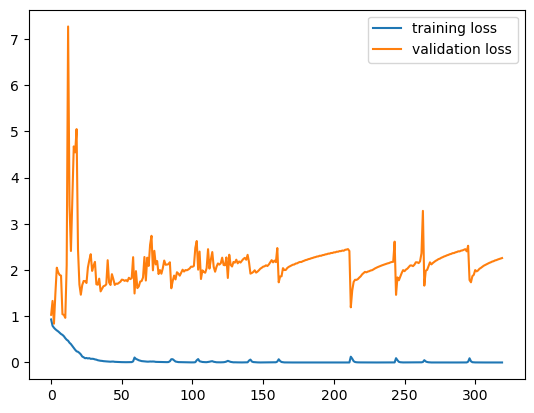

19
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1554819/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554819/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9535 loss_val: 1.1492 time: 22.9811s
 Epoch: 0001 loss_train: 0.8377 loss_val: 1.2515 time: 24.9028s
 Epoch: 0002 loss_train: 0.7966 loss_val: 1.2409 time: 23.1179s
 Epoch: 0003 loss_train: 0.7629 loss_val: 1.2022 time: 21.4620s
 Epoch: 0004 loss_train: 0.7357 loss_val: 1.3215 time: 23.4876s
 Epoch: 0005 loss_train: 0.7102 loss_val: 1.1208 time: 20.4009s
 Epoch: 0006 loss_train: 0.6938 loss_val: 1.0200 time: 22.6305s
 Epoch: 0007 loss_train: 0.6631 loss_val: 0.9816 time: 24.8281s
 Epoch: 0008 loss_train: 0.6383 loss_val: 1.1001 time: 23.2684s
 Epoch: 0009 loss_train: 0.6202 loss_val: 1.1428 time: 25.3867s
 Epoch: 0010 loss_train: 0.5915 loss_val: 1.2503 time: 25.7784s
 Epoch: 0011 loss_train: 0.5621 loss_val: 1.2234 time: 25.1611s
 Epoch: 0012 loss_train: 0.5132 loss_val: 1.0929 time: 22.5509s
 Epoch: 0013 loss_train: 0.4673 loss_val: 1.5346 time: 22.3261s
 Epoch: 0014 loss_train: 0.4265 loss_val: 1.5033 time: 23.2877s
 Epoch: 0015 loss_train: 0.3886 loss_val

 Epoch: 0129 loss_train: 0.0000 loss_val: 2.7226 time: 23.3645s
 Epoch: 0130 loss_train: 0.0000 loss_val: 2.7326 time: 24.0816s
 Epoch: 0131 loss_train: 0.0000 loss_val: 2.7424 time: 24.9206s
 Epoch: 0132 loss_train: 0.0000 loss_val: 2.7519 time: 24.5949s
 Epoch: 0133 loss_train: 0.0000 loss_val: 2.7611 time: 23.4511s
 Epoch: 0134 loss_train: 0.0000 loss_val: 2.7702 time: 21.1854s
 Epoch: 0135 loss_train: 0.0000 loss_val: 2.7791 time: 19.7683s
 Epoch: 0136 loss_train: 0.0000 loss_val: 2.7878 time: 21.3744s
 Epoch: 0137 loss_train: 0.0000 loss_val: 2.7963 time: 22.7244s
 Epoch: 0138 loss_train: 0.0000 loss_val: 2.8047 time: 21.2338s
 Epoch: 0139 loss_train: 0.0000 loss_val: 2.8130 time: 22.3030s
 Epoch: 0140 loss_train: 0.0000 loss_val: 2.8211 time: 21.0358s
 Epoch: 0141 loss_train: 0.0000 loss_val: 2.8292 time: 19.5460s
 Epoch: 0142 loss_train: 0.0000 loss_val: 2.8371 time: 23.7140s
 Epoch: 0143 loss_train: 0.0000 loss_val: 2.8449 time: 21.1894s
 Epoch: 0144 loss_train: 0.0000 loss_val

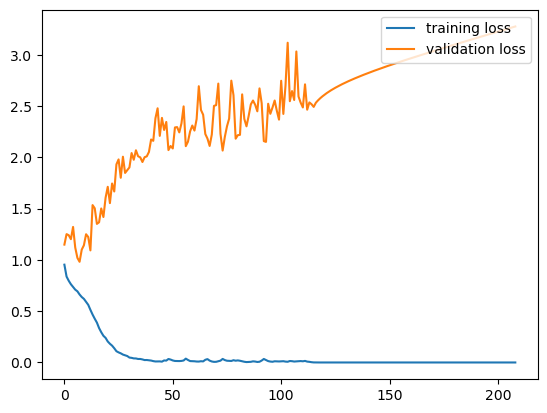

20
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
chromatin


/tmp/ipykernel_1554819/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554819/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0284 loss_val: 1.0287 time: 21.3578s
 Epoch: 0001 loss_train: 0.9094 loss_val: 1.8041 time: 24.0818s
 Epoch: 0002 loss_train: 0.8672 loss_val: 1.5160 time: 23.5449s
 Epoch: 0003 loss_train: 0.8362 loss_val: 3.9159 time: 20.5529s
 Epoch: 0004 loss_train: 0.8120 loss_val: 2.0704 time: 22.4769s
 Epoch: 0005 loss_train: 0.7827 loss_val: 1.0027 time: 23.4385s
 Epoch: 0006 loss_train: 0.7624 loss_val: 1.3045 time: 21.9943s
 Epoch: 0007 loss_train: 0.7404 loss_val: 1.3480 time: 22.1332s
 Epoch: 0008 loss_train: 0.7084 loss_val: 1.0394 time: 22.7152s
 Epoch: 0009 loss_train: 0.6925 loss_val: 1.5317 time: 22.6581s
 Epoch: 0010 loss_train: 0.6421 loss_val: 2.5085 time: 20.2844s
 Epoch: 0011 loss_train: 0.5980 loss_val: 3.6012 time: 22.4798s
 Epoch: 0012 loss_train: 0.5591 loss_val: 2.2892 time: 22.6207s
 Epoch: 0013 loss_train: 0.5294 loss_val: 1.7821 time: 19.9365s
 Epoch: 0014 loss_train: 0.4696 loss_val: 2.2430 time: 22.3333s
 Epoch: 0015 loss_train: 0.4257 loss_val

 Epoch: 0129 loss_train: 0.0059 loss_val: 2.7786 time: 23.9637s
 Epoch: 0130 loss_train: 0.0062 loss_val: 2.8651 time: 24.8273s
 Epoch: 0131 loss_train: 0.0065 loss_val: 2.8356 time: 25.2348s
 Epoch: 0132 loss_train: 0.0069 loss_val: 2.7322 time: 22.7174s
 Epoch: 0133 loss_train: 0.0066 loss_val: 2.8538 time: 22.5912s
 Epoch: 0134 loss_train: 0.0059 loss_val: 2.9048 time: 19.1109s
 Epoch: 0135 loss_train: 0.0050 loss_val: 2.9383 time: 22.5158s
 Epoch: 0136 loss_train: 0.0048 loss_val: 2.9544 time: 21.8249s
 Epoch: 0137 loss_train: 0.0055 loss_val: 3.0527 time: 22.4774s
 Epoch: 0138 loss_train: 0.0348 loss_val: 3.0062 time: 22.7830s
 Epoch: 0139 loss_train: 0.0982 loss_val: 2.2606 time: 22.9545s
 Epoch: 0140 loss_train: 0.0286 loss_val: 2.2924 time: 22.7992s
 Epoch: 0141 loss_train: 0.0125 loss_val: 2.4145 time: 24.2029s
 Epoch: 0142 loss_train: 0.0082 loss_val: 2.4937 time: 24.6180s
 Epoch: 0143 loss_train: 0.0060 loss_val: 2.5024 time: 25.5992s
 Epoch: 0144 loss_train: 0.0041 loss_val

 Epoch: 0258 loss_train: 0.0002 loss_val: 2.4795 time: 24.7514s
 Epoch: 0259 loss_train: 0.0002 loss_val: 2.4988 time: 24.5859s
 Epoch: 0260 loss_train: 0.0002 loss_val: 2.5156 time: 22.5766s
 Epoch: 0261 loss_train: 0.0003 loss_val: 2.5222 time: 18.3127s
 Epoch: 0262 loss_train: 0.0002 loss_val: 2.5215 time: 22.0012s
 Epoch: 0263 loss_train: 0.0002 loss_val: 2.5304 time: 21.3613s
 Epoch: 0264 loss_train: 0.0002 loss_val: 2.5690 time: 21.9511s
 Epoch: 0265 loss_train: 0.0003 loss_val: 2.5738 time: 23.9212s
 Epoch: 0266 loss_train: 0.0002 loss_val: 2.5692 time: 24.2434s
 Epoch: 0267 loss_train: 0.0002 loss_val: 2.5633 time: 24.8765s
 Epoch: 0268 loss_train: 0.0002 loss_val: 2.6074 time: 22.6332s
 Epoch: 0269 loss_train: 0.0002 loss_val: 2.5946 time: 17.7733s
 Epoch: 0270 loss_train: 0.0002 loss_val: 2.6072 time: 19.1125s
 Epoch: 0271 loss_train: 0.0002 loss_val: 2.6131 time: 15.4519s
 Epoch: 0272 loss_train: 0.0003 loss_val: 2.5894 time: 15.6068s
 Epoch: 0273 loss_train: 0.0008 loss_val

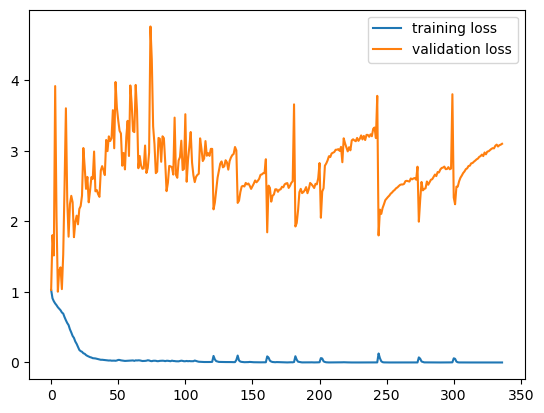

21
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
chromatin


/tmp/ipykernel_1554819/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554819/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9933 loss_val: 1.4466 time: 23.3888s
 Epoch: 0001 loss_train: 0.8628 loss_val: 1.6619 time: 20.1704s
 Epoch: 0002 loss_train: 0.8176 loss_val: 1.4573 time: 20.8006s
 Epoch: 0003 loss_train: 0.7868 loss_val: 1.0213 time: 20.0329s
 Epoch: 0004 loss_train: 0.7590 loss_val: 0.8613 time: 20.2454s
 Epoch: 0005 loss_train: 0.7293 loss_val: 1.2555 time: 23.7515s
 Epoch: 0006 loss_train: 0.7056 loss_val: 0.9512 time: 22.0541s
 Epoch: 0007 loss_train: 0.6837 loss_val: 1.0230 time: 20.6451s
 Epoch: 0008 loss_train: 0.6450 loss_val: 0.9556 time: 20.9449s
 Epoch: 0009 loss_train: 0.6110 loss_val: 1.1681 time: 21.1259s
 Epoch: 0010 loss_train: 0.5819 loss_val: 1.3176 time: 20.9651s
 Epoch: 0011 loss_train: 0.5292 loss_val: 1.6632 time: 21.1337s
 Epoch: 0012 loss_train: 0.4953 loss_val: 1.1412 time: 20.7601s
 Epoch: 0013 loss_train: 0.4636 loss_val: 1.3065 time: 23.2018s
 Epoch: 0014 loss_train: 0.4209 loss_val: 1.1871 time: 23.5804s
 Epoch: 0015 loss_train: 0.3812 loss_val

 Epoch: 0129 loss_train: 0.0044 loss_val: 2.6394 time: 22.1716s
 Epoch: 0130 loss_train: 0.0043 loss_val: 2.6128 time: 22.7708s
 Epoch: 0131 loss_train: 0.0044 loss_val: 2.6323 time: 21.6601s
 Epoch: 0132 loss_train: 0.0043 loss_val: 2.6425 time: 19.8475s
 Epoch: 0133 loss_train: 0.0044 loss_val: 2.6479 time: 21.2432s
 Epoch: 0134 loss_train: 0.0052 loss_val: 2.7784 time: 18.2463s
 Epoch: 0135 loss_train: 0.0037 loss_val: 2.7284 time: 20.2861s
 Epoch: 0136 loss_train: 0.0033 loss_val: 2.7001 time: 20.4982s
 Epoch: 0137 loss_train: 0.0032 loss_val: 2.6944 time: 22.7857s
 Epoch: 0138 loss_train: 0.0034 loss_val: 2.7566 time: 22.1984s
 Epoch: 0139 loss_train: 0.0029 loss_val: 2.7442 time: 23.4551s
 Epoch: 0140 loss_train: 0.0024 loss_val: 2.8068 time: 22.0667s
 Epoch: 0141 loss_train: 0.0022 loss_val: 2.7800 time: 24.3804s
 Epoch: 0142 loss_train: 0.0027 loss_val: 2.8732 time: 21.5509s
 Epoch: 0143 loss_train: 0.0297 loss_val: 2.7598 time: 23.5275s
 Epoch: 0144 loss_train: 0.1710 loss_val

 Epoch: 0258 loss_train: 0.0102 loss_val: 3.0781 time: 22.1867s
 Epoch: 0259 loss_train: 0.0428 loss_val: 2.2271 time: 22.0730s
 Epoch: 0260 loss_train: 0.0330 loss_val: 2.0054 time: 24.2199s
 Epoch: 0261 loss_train: 0.0076 loss_val: 2.1488 time: 24.0551s
 Epoch: 0262 loss_train: 0.0023 loss_val: 2.1554 time: 24.2312s
 Epoch: 0263 loss_train: 0.0008 loss_val: 2.2379 time: 20.8394s
 Epoch: 0264 loss_train: 0.0003 loss_val: 2.2647 time: 22.7416s
 Epoch: 0265 loss_train: 0.0002 loss_val: 2.2953 time: 21.7947s
 Epoch: 0266 loss_train: 0.0002 loss_val: 2.3232 time: 22.9569s
 Epoch: 0267 loss_train: 0.0001 loss_val: 2.3448 time: 23.6088s
 Epoch: 0268 loss_train: 0.0001 loss_val: 2.3661 time: 23.4772s
 Epoch: 0269 loss_train: 0.0001 loss_val: 2.3836 time: 22.1198s
 Epoch: 0270 loss_train: 0.0001 loss_val: 2.4012 time: 21.7136s
 Epoch: 0271 loss_train: 0.0001 loss_val: 2.4155 time: 22.9604s
 Epoch: 0272 loss_train: 0.0001 loss_val: 2.4302 time: 22.3309s
 Epoch: 0273 loss_train: 0.0001 loss_val

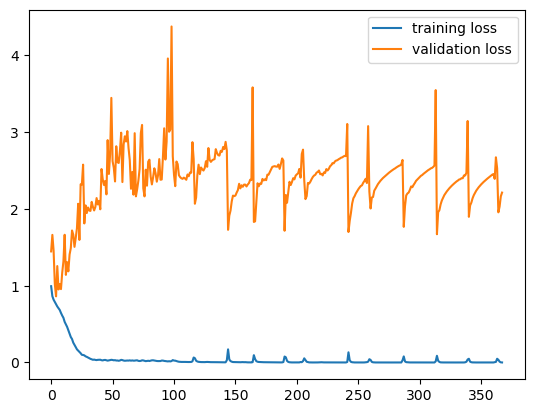

22
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
P57
P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1554819/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554819/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0031 loss_val: 1.4304 time: 21.3553s
 Epoch: 0001 loss_train: 0.8696 loss_val: 1.0250 time: 22.9356s
 Epoch: 0002 loss_train: 0.8252 loss_val: 1.1446 time: 22.5308s
 Epoch: 0003 loss_train: 0.7989 loss_val: 1.5911 time: 20.8035s
 Epoch: 0004 loss_train: 0.7665 loss_val: 1.4431 time: 23.5381s
 Epoch: 0005 loss_train: 0.7415 loss_val: 2.5425 time: 24.5986s
 Epoch: 0006 loss_train: 0.7137 loss_val: 3.4290 time: 24.4237s
 Epoch: 0007 loss_train: 0.6886 loss_val: 1.4422 time: 23.7015s
 Epoch: 0008 loss_train: 0.6630 loss_val: 1.3046 time: 26.2588s
 Epoch: 0009 loss_train: 0.6380 loss_val: 1.4845 time: 22.7443s
 Epoch: 0010 loss_train: 0.6052 loss_val: 1.1713 time: 22.6721s
 Epoch: 0011 loss_train: 0.5750 loss_val: 1.1388 time: 19.7614s
 Epoch: 0012 loss_train: 0.5347 loss_val: 1.1429 time: 22.1560s
 Epoch: 0013 loss_train: 0.4825 loss_val: 1.4785 time: 17.7515s
 Epoch: 0014 loss_train: 0.4474 loss_val: 2.1681 time: 16.5310s
 Epoch: 0015 loss_train: 0.3865 loss_val

 Epoch: 0129 loss_train: 0.0078 loss_val: 2.5939 time: 19.4492s
 Epoch: 0130 loss_train: 0.0071 loss_val: 2.6147 time: 20.5248s
 Epoch: 0131 loss_train: 0.0079 loss_val: 2.7424 time: 21.6796s
 Epoch: 0132 loss_train: 0.0083 loss_val: 2.6418 time: 20.9584s
 Epoch: 0133 loss_train: 0.0129 loss_val: 2.8077 time: 20.9284s
 Epoch: 0134 loss_train: 0.0680 loss_val: 2.2881 time: 20.6311s
 Epoch: 0135 loss_train: 0.0580 loss_val: 2.1771 time: 22.4832s
 Epoch: 0136 loss_train: 0.0255 loss_val: 2.0831 time: 21.6406s
 Epoch: 0137 loss_train: 0.0147 loss_val: 2.2579 time: 21.5960s
 Epoch: 0138 loss_train: 0.0101 loss_val: 2.3674 time: 20.7288s
 Epoch: 0139 loss_train: 0.0079 loss_val: 2.3919 time: 19.5310s
 Epoch: 0140 loss_train: 0.0070 loss_val: 2.4736 time: 22.1712s
 Epoch: 0141 loss_train: 0.0071 loss_val: 2.3997 time: 22.1333s
 Epoch: 0142 loss_train: 0.0070 loss_val: 2.3345 time: 21.2795s
 Epoch: 0143 loss_train: 0.0069 loss_val: 2.3665 time: 21.0075s
 Epoch: 0144 loss_train: 0.0070 loss_val

 Epoch: 0258 loss_train: 0.0002 loss_val: 2.8222 time: 23.3515s
 Epoch: 0259 loss_train: 0.0001 loss_val: 2.8586 time: 23.5302s
 Epoch: 0260 loss_train: 0.0001 loss_val: 2.8438 time: 22.6603s
 Epoch: 0261 loss_train: 0.0001 loss_val: 2.8583 time: 23.1981s
 Epoch: 0262 loss_train: 0.0001 loss_val: 2.8660 time: 24.0747s
 Epoch: 0263 loss_train: 0.0476 loss_val: 2.9301 time: 23.8034s
 Epoch: 0264 loss_train: 0.0824 loss_val: 1.9149 time: 23.1428s
 Epoch: 0265 loss_train: 0.0221 loss_val: 2.1734 time: 22.8092s
 Epoch: 0266 loss_train: 0.0091 loss_val: 2.2685 time: 22.7805s
 Epoch: 0267 loss_train: 0.0036 loss_val: 2.4199 time: 24.1579s
 Epoch: 0268 loss_train: 0.0029 loss_val: 2.3995 time: 22.4810s
 Epoch: 0269 loss_train: 0.0014 loss_val: 2.4236 time: 23.5297s
 Epoch: 0270 loss_train: 0.0010 loss_val: 2.4986 time: 22.2140s
 Epoch: 0271 loss_train: 0.0009 loss_val: 2.5117 time: 21.7256s
 Epoch: 0272 loss_train: 0.0005 loss_val: 2.5517 time: 24.5250s
 Epoch: 0273 loss_train: 0.0003 loss_val

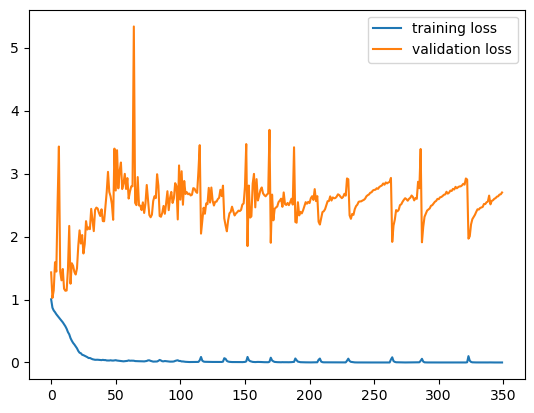

23
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
hold out: P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
hold out: P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1554819/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554819/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0135 loss_val: 1.1697 time: 17.1824s
 Epoch: 0001 loss_train: 0.8991 loss_val: 1.1169 time: 23.2464s
 Epoch: 0002 loss_train: 0.8596 loss_val: 0.9397 time: 18.7929s
 Epoch: 0003 loss_train: 0.8281 loss_val: 0.9975 time: 20.6198s
 Epoch: 0004 loss_train: 0.7980 loss_val: 2.4553 time: 24.6949s
 Epoch: 0005 loss_train: 0.7645 loss_val: 1.1221 time: 23.0587s
 Epoch: 0006 loss_train: 0.7478 loss_val: 2.6975 time: 22.8514s
 Epoch: 0007 loss_train: 0.7296 loss_val: 0.9232 time: 22.9295s
 Epoch: 0008 loss_train: 0.7059 loss_val: 1.4025 time: 22.2300s
 Epoch: 0009 loss_train: 0.6762 loss_val: 1.7737 time: 20.4036s
 Epoch: 0010 loss_train: 0.6506 loss_val: 3.2809 time: 24.2725s
 Epoch: 0011 loss_train: 0.6234 loss_val: 1.1926 time: 22.2320s
 Epoch: 0012 loss_train: 0.5676 loss_val: 1.3483 time: 21.9642s
 Epoch: 0013 loss_train: 0.5213 loss_val: 1.5006 time: 23.5053s
 Epoch: 0014 loss_train: 0.4920 loss_val: 2.2767 time: 22.1613s
 Epoch: 0015 loss_train: 0.4352 loss_val

 Epoch: 0129 loss_train: 0.0114 loss_val: 2.2963 time: 21.0258s
 Epoch: 0130 loss_train: 0.0093 loss_val: 2.3395 time: 19.1978s
 Epoch: 0131 loss_train: 0.0082 loss_val: 2.4467 time: 22.1061s
 Epoch: 0132 loss_train: 0.0078 loss_val: 2.4849 time: 20.2243s
 Epoch: 0133 loss_train: 0.0093 loss_val: 2.4190 time: 19.6390s
 Epoch: 0134 loss_train: 0.0079 loss_val: 2.4254 time: 21.5985s
 Epoch: 0135 loss_train: 0.0075 loss_val: 2.4166 time: 22.1543s
 Epoch: 0136 loss_train: 0.0072 loss_val: 2.4813 time: 20.2204s
 Epoch: 0137 loss_train: 0.0072 loss_val: 2.4643 time: 19.2272s
 Epoch: 0138 loss_train: 0.0073 loss_val: 2.5285 time: 20.5315s
 Epoch: 0139 loss_train: 0.0072 loss_val: 2.5585 time: 21.8904s
 Epoch: 0140 loss_train: 0.0069 loss_val: 2.7366 time: 21.2291s
 Epoch: 0141 loss_train: 0.0152 loss_val: 3.0042 time: 20.0766s
 Epoch: 0142 loss_train: 0.0840 loss_val: 1.6964 time: 21.2224s
 Epoch: 0143 loss_train: 0.0526 loss_val: 1.9902 time: 20.8276s
 Epoch: 0144 loss_train: 0.0227 loss_val

 Epoch: 0258 loss_train: 0.0002 loss_val: 2.6783 time: 19.7760s
 Epoch: 0259 loss_train: 0.0002 loss_val: 2.6870 time: 21.5855s
 Epoch: 0260 loss_train: 0.0002 loss_val: 2.6987 time: 22.6737s
 Epoch: 0261 loss_train: 0.0001 loss_val: 2.7057 time: 21.5345s
 Epoch: 0262 loss_train: 0.0002 loss_val: 2.7157 time: 22.9513s
 Epoch: 0263 loss_train: 0.0002 loss_val: 2.7325 time: 19.9928s
 Epoch: 0264 loss_train: 0.0003 loss_val: 2.7316 time: 22.2045s
 Epoch: 0265 loss_train: 0.0002 loss_val: 2.7716 time: 24.7169s
 Epoch: 0266 loss_train: 0.0258 loss_val: 3.6636 time: 24.6016s
 Epoch: 0267 loss_train: 0.1042 loss_val: 1.9274 time: 22.5510s
 Epoch: 0268 loss_train: 0.0329 loss_val: 1.8894 time: 22.3956s
 Epoch: 0269 loss_train: 0.0097 loss_val: 2.1533 time: 23.6927s
 Epoch: 0270 loss_train: 0.0040 loss_val: 2.1924 time: 24.0475s
 Epoch: 0271 loss_train: 0.0021 loss_val: 2.2068 time: 22.0083s
 Epoch: 0272 loss_train: 0.0009 loss_val: 2.1979 time: 21.6486s
 Epoch: 0273 loss_train: 0.0005 loss_val

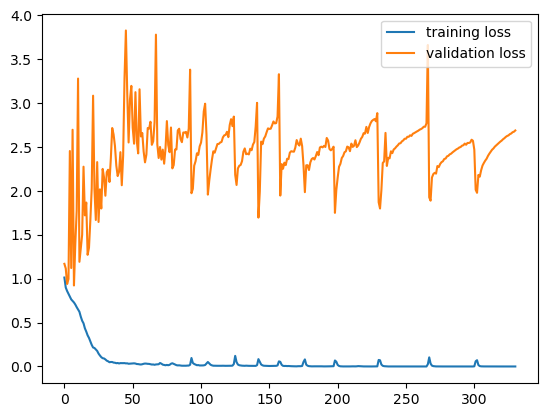

24
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1554819/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554819/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9328 loss_val: 1.4862 time: 24.2459s
 Epoch: 0001 loss_train: 0.8024 loss_val: 1.6815 time: 24.6144s
 Epoch: 0002 loss_train: 0.7643 loss_val: 2.8192 time: 23.2223s
 Epoch: 0003 loss_train: 0.7369 loss_val: 5.0836 time: 23.5704s
 Epoch: 0004 loss_train: 0.7120 loss_val: 1.0867 time: 24.0639s
 Epoch: 0005 loss_train: 0.6848 loss_val: 1.2633 time: 23.6700s
 Epoch: 0006 loss_train: 0.6536 loss_val: 1.2941 time: 24.9759s
 Epoch: 0007 loss_train: 0.6322 loss_val: 1.1071 time: 23.6401s
 Epoch: 0008 loss_train: 0.6161 loss_val: 0.8873 time: 24.0458s
 Epoch: 0009 loss_train: 0.5894 loss_val: 2.0760 time: 24.5109s
 Epoch: 0010 loss_train: 0.5566 loss_val: 1.5713 time: 24.5529s
 Epoch: 0011 loss_train: 0.5184 loss_val: 2.0272 time: 25.7262s
 Epoch: 0012 loss_train: 0.4856 loss_val: 1.4139 time: 25.6724s
 Epoch: 0013 loss_train: 0.4400 loss_val: 1.5027 time: 24.2317s
 Epoch: 0014 loss_train: 0.4097 loss_val: 2.0335 time: 21.8053s
 Epoch: 0015 loss_train: 0.3802 loss_val

 Epoch: 0129 loss_train: 0.0060 loss_val: 2.0996 time: 25.3411s
 Epoch: 0130 loss_train: 0.0052 loss_val: 2.1065 time: 23.9020s
 Epoch: 0131 loss_train: 0.0046 loss_val: 2.2155 time: 23.7830s
 Epoch: 0132 loss_train: 0.0048 loss_val: 2.1826 time: 22.2617s
 Epoch: 0133 loss_train: 0.0050 loss_val: 2.2292 time: 22.9252s
 Epoch: 0134 loss_train: 0.0048 loss_val: 2.2268 time: 22.5058s
 Epoch: 0135 loss_train: 0.0527 loss_val: 4.6481 time: 21.6225s
 Epoch: 0136 loss_train: 0.0757 loss_val: 2.3837 time: 21.9814s
 Epoch: 0137 loss_train: 0.0323 loss_val: 2.0007 time: 21.1800s
 Epoch: 0138 loss_train: 0.0212 loss_val: 2.0317 time: 18.7405s
 Epoch: 0139 loss_train: 0.0157 loss_val: 1.9884 time: 17.5674s
 Epoch: 0140 loss_train: 0.0103 loss_val: 2.2929 time: 16.3345s
 Epoch: 0141 loss_train: 0.0077 loss_val: 2.2330 time: 17.9505s
 Epoch: 0142 loss_train: 0.0063 loss_val: 2.2275 time: 17.3376s
 Epoch: 0143 loss_train: 0.0057 loss_val: 2.2431 time: 19.4695s
 Epoch: 0144 loss_train: 0.0059 loss_val

 Epoch: 0258 loss_train: 0.0007 loss_val: 2.0166 time: 20.1675s
 Epoch: 0259 loss_train: 0.0004 loss_val: 2.0510 time: 23.1432s
 Epoch: 0260 loss_train: 0.0003 loss_val: 2.0767 time: 23.4014s
 Epoch: 0261 loss_train: 0.0004 loss_val: 2.1011 time: 23.2071s
 Epoch: 0262 loss_train: 0.0004 loss_val: 2.1198 time: 24.9629s
 Epoch: 0263 loss_train: 0.0004 loss_val: 2.1306 time: 22.8073s
 Epoch: 0264 loss_train: 0.0005 loss_val: 2.1463 time: 23.5364s
 Epoch: 0265 loss_train: 0.0005 loss_val: 2.1601 time: 20.6112s
 Epoch: 0266 loss_train: 0.0008 loss_val: 2.1677 time: 20.8119s
 Epoch: 0267 loss_train: 0.0004 loss_val: 2.1789 time: 20.4858s
 Epoch: 0268 loss_train: 0.0005 loss_val: 2.2206 time: 21.3680s
 Epoch: 0269 loss_train: 0.0011 loss_val: 2.2040 time: 22.2603s
 Epoch: 0270 loss_train: 0.0013 loss_val: 2.2664 time: 23.6803s
 Epoch: 0271 loss_train: 0.0006 loss_val: 2.2007 time: 22.6974s
 Epoch: 0272 loss_train: 0.0003 loss_val: 2.2244 time: 23.5446s
 Epoch: 0273 loss_train: 0.0003 loss_val

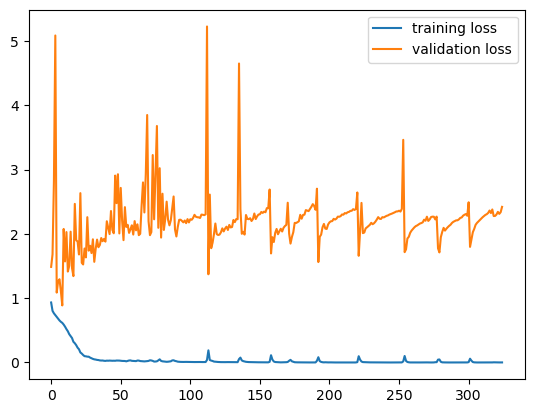

25
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1554819/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554819/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9554 loss_val: 1.1102 time: 21.2854s
 Epoch: 0001 loss_train: 0.8461 loss_val: 0.9101 time: 23.6503s
 Epoch: 0002 loss_train: 0.7992 loss_val: 0.8658 time: 21.6657s
 Epoch: 0003 loss_train: 0.7717 loss_val: 0.8919 time: 21.1290s
 Epoch: 0004 loss_train: 0.7384 loss_val: 0.9021 time: 19.7256s
 Epoch: 0005 loss_train: 0.7068 loss_val: 1.1393 time: 19.8434s
 Epoch: 0006 loss_train: 0.6830 loss_val: 1.8387 time: 22.3640s
 Epoch: 0007 loss_train: 0.6626 loss_val: 1.0241 time: 21.0614s
 Epoch: 0008 loss_train: 0.6166 loss_val: 1.0884 time: 21.7835s
 Epoch: 0009 loss_train: 0.5830 loss_val: 1.0413 time: 21.6751s
 Epoch: 0010 loss_train: 0.5419 loss_val: 1.0012 time: 19.7147s
 Epoch: 0011 loss_train: 0.5022 loss_val: 1.0679 time: 20.1629s
 Epoch: 0012 loss_train: 0.4701 loss_val: 1.2073 time: 22.6668s
 Epoch: 0013 loss_train: 0.4232 loss_val: 1.1240 time: 21.1876s
 Epoch: 0014 loss_train: 0.3984 loss_val: 1.8716 time: 21.6826s
 Epoch: 0015 loss_train: 0.3589 loss_val

 Epoch: 0129 loss_train: 0.0000 loss_val: 2.7256 time: 24.6539s
 Epoch: 0130 loss_train: 0.0000 loss_val: 2.7316 time: 24.7197s
 Epoch: 0131 loss_train: 0.0000 loss_val: 2.7376 time: 23.4934s
 Epoch: 0132 loss_train: 0.0000 loss_val: 2.7438 time: 22.6844s
 Epoch: 0133 loss_train: 0.0000 loss_val: 2.7497 time: 24.6921s
 Epoch: 0134 loss_train: 0.0000 loss_val: 2.7557 time: 23.2525s
 Epoch: 0135 loss_train: 0.0000 loss_val: 2.7618 time: 24.7099s
 Epoch: 0136 loss_train: 0.0000 loss_val: 2.7678 time: 25.1254s
 Epoch: 0137 loss_train: 0.0000 loss_val: 2.7738 time: 22.1659s
 Epoch: 0138 loss_train: 0.0000 loss_val: 2.7799 time: 22.7042s
 Epoch: 0139 loss_train: 0.0000 loss_val: 2.7858 time: 23.2595s
 Epoch: 0140 loss_train: 0.0000 loss_val: 2.7918 time: 21.4622s
 Epoch: 0141 loss_train: 0.0000 loss_val: 2.7979 time: 22.8391s
 Epoch: 0142 loss_train: 0.0000 loss_val: 2.8038 time: 21.9829s
 Epoch: 0143 loss_train: 0.0000 loss_val: 2.8097 time: 23.8507s
 Epoch: 0144 loss_train: 0.0000 loss_val

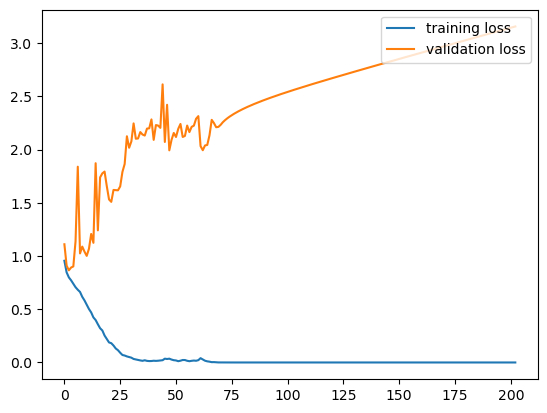

26
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
chromatin


/tmp/ipykernel_1554819/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554819/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0236 loss_val: 1.2801 time: 22.2633s
 Epoch: 0001 loss_train: 0.9085 loss_val: 1.4669 time: 22.1769s
 Epoch: 0002 loss_train: 0.8663 loss_val: 2.3959 time: 19.1843s
 Epoch: 0003 loss_train: 0.8305 loss_val: 2.5944 time: 20.0082s
 Epoch: 0004 loss_train: 0.8060 loss_val: 0.9826 time: 22.6952s
 Epoch: 0005 loss_train: 0.7787 loss_val: 1.1795 time: 24.3662s
 Epoch: 0006 loss_train: 0.7506 loss_val: 1.0447 time: 21.3254s
 Epoch: 0007 loss_train: 0.7215 loss_val: 1.3110 time: 21.9696s
 Epoch: 0008 loss_train: 0.6924 loss_val: 1.1067 time: 22.7448s
 Epoch: 0009 loss_train: 0.6635 loss_val: 1.3769 time: 24.6534s
 Epoch: 0010 loss_train: 0.6405 loss_val: 1.4426 time: 22.0957s
 Epoch: 0011 loss_train: 0.6143 loss_val: 1.9050 time: 19.9071s
 Epoch: 0012 loss_train: 0.5742 loss_val: 2.2260 time: 23.2557s
 Epoch: 0013 loss_train: 0.5279 loss_val: 2.7203 time: 21.6562s
 Epoch: 0014 loss_train: 0.4726 loss_val: 1.2473 time: 24.0733s
 Epoch: 0015 loss_train: 0.4296 loss_val

 Epoch: 0129 loss_train: 0.0061 loss_val: 2.8412 time: 24.1933s
 Epoch: 0130 loss_train: 0.0059 loss_val: 3.5891 time: 23.1836s
 Epoch: 0131 loss_train: 0.0039 loss_val: 2.9161 time: 22.9473s
 Epoch: 0132 loss_train: 0.0029 loss_val: 3.0375 time: 21.4977s
 Epoch: 0133 loss_train: 0.0022 loss_val: 3.1939 time: 20.4110s
 Epoch: 0134 loss_train: 0.0027 loss_val: 3.0224 time: 19.1502s
 Epoch: 0135 loss_train: 0.0021 loss_val: 3.0261 time: 24.2304s
 Epoch: 0136 loss_train: 0.0022 loss_val: 3.2175 time: 23.2055s
 Epoch: 0137 loss_train: 0.0034 loss_val: 3.0905 time: 25.2733s
 Epoch: 0138 loss_train: 0.0035 loss_val: 3.2357 time: 25.6923s
 Epoch: 0139 loss_train: 0.0037 loss_val: 3.1835 time: 23.0110s
 Epoch: 0140 loss_train: 0.1349 loss_val: 1.5880 time: 21.2828s
 Epoch: 0141 loss_train: 0.0688 loss_val: 2.2466 time: 20.4545s
 Epoch: 0142 loss_train: 0.0266 loss_val: 2.7422 time: 20.5399s
 Epoch: 0143 loss_train: 0.0146 loss_val: 2.8245 time: 24.1783s
 Epoch: 0144 loss_train: 0.0087 loss_val

 Epoch: 0258 loss_train: 0.0006 loss_val: 3.1712 time: 21.2265s
 Epoch: 0259 loss_train: 0.0006 loss_val: 3.2480 time: 21.4675s
 Epoch: 0260 loss_train: 0.0010 loss_val: 3.1173 time: 21.0065s
 Epoch: 0261 loss_train: 0.0004 loss_val: 3.1057 time: 22.7681s
 Epoch: 0262 loss_train: 0.0006 loss_val: 3.2039 time: 22.8681s
 Epoch: 0263 loss_train: 0.0002 loss_val: 3.2505 time: 23.4640s
 Epoch: 0264 loss_train: 0.0001 loss_val: 3.2876 time: 24.0594s
 Epoch: 0265 loss_train: 0.0002 loss_val: 3.3081 time: 23.8654s
 Epoch: 0266 loss_train: 0.0001 loss_val: 3.3427 time: 24.3260s
 Epoch: 0267 loss_train: 0.0001 loss_val: 3.3701 time: 23.6515s
 Epoch: 0268 loss_train: 0.0001 loss_val: 3.3987 time: 23.6935s
 Epoch: 0269 loss_train: 0.0002 loss_val: 3.3794 time: 19.9926s
 Epoch: 0270 loss_train: 0.0001 loss_val: 3.4164 time: 21.2743s
 Epoch: 0271 loss_train: 0.0001 loss_val: 3.4305 time: 22.8232s
 Epoch: 0272 loss_train: 0.0001 loss_val: 3.4559 time: 23.5122s
 Epoch: 0273 loss_train: 0.0001 loss_val

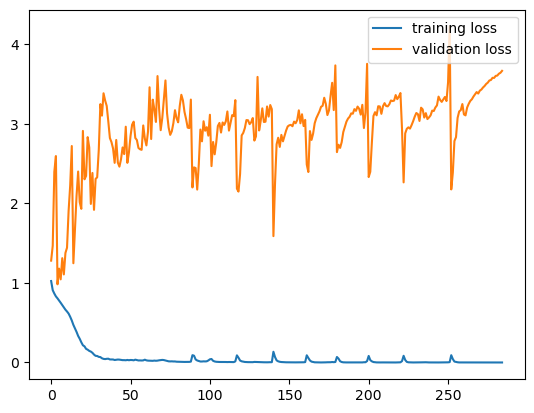

27
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
chromatin


/tmp/ipykernel_1554819/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554819/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9949 loss_val: 1.3526 time: 22.0175s
 Epoch: 0001 loss_train: 0.8558 loss_val: 1.1036 time: 23.3225s
 Epoch: 0002 loss_train: 0.8198 loss_val: 1.6185 time: 23.5603s
 Epoch: 0003 loss_train: 0.7915 loss_val: 2.6957 time: 24.8079s
 Epoch: 0004 loss_train: 0.7660 loss_val: 1.5346 time: 25.0937s
 Epoch: 0005 loss_train: 0.7393 loss_val: 0.9398 time: 21.3649s
 Epoch: 0006 loss_train: 0.7130 loss_val: 1.0905 time: 20.5806s
 Epoch: 0007 loss_train: 0.6922 loss_val: 6.0372 time: 23.8384s
 Epoch: 0008 loss_train: 0.6587 loss_val: 1.5904 time: 21.8528s
 Epoch: 0009 loss_train: 0.6295 loss_val: 1.1958 time: 23.1046s
 Epoch: 0010 loss_train: 0.6061 loss_val: 1.0124 time: 23.1006s
 Epoch: 0011 loss_train: 0.5685 loss_val: 1.4639 time: 21.7076s
 Epoch: 0012 loss_train: 0.5207 loss_val: 1.4649 time: 23.1570s
 Epoch: 0013 loss_train: 0.4799 loss_val: 1.1483 time: 22.7164s
 Epoch: 0014 loss_train: 0.4589 loss_val: 1.0786 time: 23.3875s
 Epoch: 0015 loss_train: 0.4028 loss_val

 Epoch: 0129 loss_train: 0.0053 loss_val: 2.4253 time: 21.6119s
 Epoch: 0130 loss_train: 0.0043 loss_val: 2.4202 time: 22.4941s
 Epoch: 0131 loss_train: 0.0041 loss_val: 2.4547 time: 20.2547s
 Epoch: 0132 loss_train: 0.0049 loss_val: 2.5228 time: 20.5725s
 Epoch: 0133 loss_train: 0.0056 loss_val: 2.5820 time: 18.3643s
 Epoch: 0134 loss_train: 0.0063 loss_val: 2.7387 time: 22.4511s
 Epoch: 0135 loss_train: 0.0070 loss_val: 2.5970 time: 21.0572s
 Epoch: 0136 loss_train: 0.0059 loss_val: 2.5186 time: 23.3176s
 Epoch: 0137 loss_train: 0.0048 loss_val: 2.9733 time: 23.4253s
 Epoch: 0138 loss_train: 0.0046 loss_val: 2.6536 time: 22.5732s
 Epoch: 0139 loss_train: 0.0371 loss_val: 2.9524 time: 22.7826s
 Epoch: 0140 loss_train: 0.0689 loss_val: 2.0455 time: 22.3961s
 Epoch: 0141 loss_train: 0.0312 loss_val: 2.0940 time: 22.6142s
 Epoch: 0142 loss_train: 0.0139 loss_val: 2.3942 time: 20.1994s
 Epoch: 0143 loss_train: 0.0101 loss_val: 2.3551 time: 20.1741s
 Epoch: 0144 loss_train: 0.0076 loss_val

 Epoch: 0258 loss_train: 0.0004 loss_val: 2.3016 time: 20.9797s
 Epoch: 0259 loss_train: 0.0002 loss_val: 2.3320 time: 22.6194s
 Epoch: 0260 loss_train: 0.0001 loss_val: 2.3573 time: 22.5458s
 Epoch: 0261 loss_train: 0.0001 loss_val: 2.3798 time: 21.6071s
 Epoch: 0262 loss_train: 0.0001 loss_val: 2.4001 time: 21.1808s
 Epoch: 0263 loss_train: 0.0001 loss_val: 2.4188 time: 22.1283s
 Epoch: 0264 loss_train: 0.0001 loss_val: 2.4362 time: 19.6396s
 Epoch: 0265 loss_train: 0.0001 loss_val: 2.4526 time: 20.5478s
 Epoch: 0266 loss_train: 0.0001 loss_val: 2.4685 time: 20.8316s
 Epoch: 0267 loss_train: 0.0001 loss_val: 2.4827 time: 19.4554s
 Epoch: 0268 loss_train: 0.0002 loss_val: 2.4896 time: 21.7152s
 Epoch: 0269 loss_train: 0.0002 loss_val: 2.4963 time: 21.7359s
 Epoch: 0270 loss_train: 0.0001 loss_val: 2.5118 time: 20.6542s
 Epoch: 0271 loss_train: 0.0001 loss_val: 2.5270 time: 23.6109s
 Epoch: 0272 loss_train: 0.0001 loss_val: 2.5374 time: 23.3510s
 Epoch: 0273 loss_train: 0.0001 loss_val

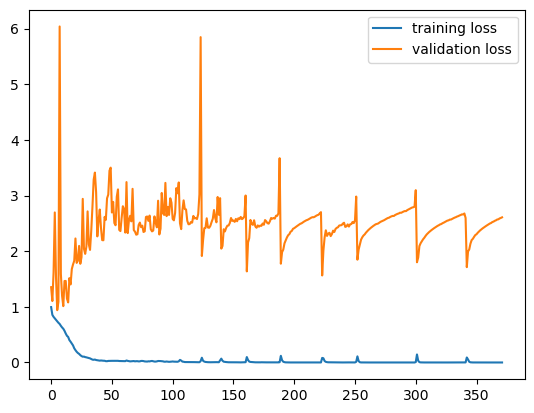

28
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
P57
P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1554819/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554819/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9916 loss_val: 1.0090 time: 19.9465s
 Epoch: 0001 loss_train: 0.8827 loss_val: 0.9827 time: 18.7276s
 Epoch: 0002 loss_train: 0.8362 loss_val: 1.2718 time: 18.8622s
 Epoch: 0003 loss_train: 0.8049 loss_val: 1.2621 time: 20.6322s
 Epoch: 0004 loss_train: 0.7838 loss_val: 0.9656 time: 20.6504s
 Epoch: 0005 loss_train: 0.7588 loss_val: 1.1547 time: 18.6574s
 Epoch: 0006 loss_train: 0.7277 loss_val: 1.3298 time: 19.8168s
 Epoch: 0007 loss_train: 0.7045 loss_val: 0.9005 time: 18.2964s
 Epoch: 0008 loss_train: 0.6750 loss_val: 1.0036 time: 21.0424s
 Epoch: 0009 loss_train: 0.6463 loss_val: 1.6123 time: 18.4453s
 Epoch: 0010 loss_train: 0.6053 loss_val: 1.3966 time: 20.5048s
 Epoch: 0011 loss_train: 0.5635 loss_val: 1.1115 time: 19.2008s
 Epoch: 0012 loss_train: 0.5192 loss_val: 1.9383 time: 19.5826s
 Epoch: 0013 loss_train: 0.4867 loss_val: 1.3357 time: 24.5611s
 Epoch: 0014 loss_train: 0.4510 loss_val: 2.2910 time: 22.0509s
 Epoch: 0015 loss_train: 0.4033 loss_val

 Epoch: 0129 loss_train: 0.0050 loss_val: 2.6655 time: 22.7991s
 Epoch: 0130 loss_train: 0.0043 loss_val: 2.6875 time: 21.0595s
 Epoch: 0131 loss_train: 0.0093 loss_val: 3.5339 time: 23.1563s
 Epoch: 0132 loss_train: 0.0821 loss_val: 1.7534 time: 20.6449s
 Epoch: 0133 loss_train: 0.0467 loss_val: 2.2519 time: 22.3471s
 Epoch: 0134 loss_train: 0.0174 loss_val: 2.5589 time: 22.0756s
 Epoch: 0135 loss_train: 0.0096 loss_val: 2.4898 time: 20.5115s
 Epoch: 0136 loss_train: 0.0063 loss_val: 2.7373 time: 17.6323s
 Epoch: 0137 loss_train: 0.0070 loss_val: 2.9193 time: 22.3428s
 Epoch: 0138 loss_train: 0.0056 loss_val: 2.5855 time: 21.4712s
 Epoch: 0139 loss_train: 0.0046 loss_val: 2.6117 time: 20.8184s
 Epoch: 0140 loss_train: 0.0050 loss_val: 2.5743 time: 21.5241s
 Epoch: 0141 loss_train: 0.0035 loss_val: 2.5693 time: 22.9906s
 Epoch: 0142 loss_train: 0.0040 loss_val: 2.6171 time: 24.2449s
 Epoch: 0143 loss_train: 0.0057 loss_val: 2.6046 time: 22.8026s
 Epoch: 0144 loss_train: 0.0049 loss_val

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 Epoch: 0186 loss_train: 0.0000 loss_val: 3.0846 time: 24.8083s
 Epoch: 0187 loss_train: 0.0000 loss_val: 3.0904 time: 24.3673s
 Epoch: 0188 loss_train: 0.0000 loss_val: 3.0962 time: 23.4695s
 Epoch: 0189 loss_train: 0.0000 loss_val: 3.1021 time: 23.9452s
 Epoch: 0190 loss_train: 0.0000 loss_val: 3.1079 time: 25.9351s
 Epoch: 0191 loss_train: 0.0000 loss_val: 3.1138 time: 21.8462s
 Epoch: 0192 loss_train: 0.0000 loss_val: 3.1196 time: 22.9379s
 Epoch: 0193 loss_train: 0.0000 loss_val: 3.1255 time: 24.0022s
 Epoch: 0194 loss_train: 0.0000 loss_val: 3.1313 time: 23.7297s
 Epoch: 0195 loss_train: 0.0000 loss_val: 3.1371 time: 24.9551s
 Epoch: 0196 loss_train: 0.0000 loss_val: 3.1429 time: 24.5712s
 Epoch: 0197 loss_train: 0.0000 loss_val: 3.1487 time: 24.0527s
 Epoch: 0198 loss_train: 0.0000 loss_val: 3.1545 time: 24.5020s
 Epoch: 0199 loss_train: 0.0000 loss_val: 3.1603 time: 24.0103s
 Epoch: 0200 loss_train: 0.0000 loss_val: 3.1662 time: 24.7362s
 Epoch: 0201 loss_train: 0.0000 loss_val

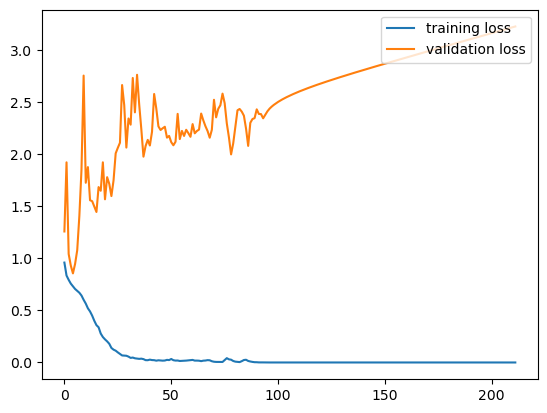

32
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
chromatin


/tmp/ipykernel_1554819/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554819/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0302 loss_val: 1.0135 time: 24.5196s
 Epoch: 0001 loss_train: 0.9072 loss_val: 1.0342 time: 23.3636s
 Epoch: 0002 loss_train: 0.8680 loss_val: 0.9207 time: 24.4804s
 Epoch: 0003 loss_train: 0.8379 loss_val: 0.9403 time: 23.2856s
 Epoch: 0004 loss_train: 0.8086 loss_val: 1.2223 time: 22.2028s
 Epoch: 0005 loss_train: 0.7871 loss_val: 1.1712 time: 21.4434s
 Epoch: 0006 loss_train: 0.7655 loss_val: 1.0641 time: 22.4955s
 Epoch: 0007 loss_train: 0.7406 loss_val: 1.2080 time: 24.1568s
 Epoch: 0008 loss_train: 0.7174 loss_val: 1.6088 time: 25.5485s
 Epoch: 0009 loss_train: 0.6924 loss_val: 1.1491 time: 24.7184s
 Epoch: 0010 loss_train: 0.6565 loss_val: 2.4498 time: 22.2700s
 Epoch: 0011 loss_train: 0.6311 loss_val: 1.6806 time: 24.0758s
 Epoch: 0012 loss_train: 0.5727 loss_val: 1.1818 time: 23.5687s
 Epoch: 0013 loss_train: 0.5467 loss_val: 1.1900 time: 25.7532s
 Epoch: 0014 loss_train: 0.5122 loss_val: 1.3703 time: 24.6440s
 Epoch: 0015 loss_train: 0.4567 loss_val

 Epoch: 0129 loss_train: 0.0061 loss_val: 2.7504 time: 26.6190s
 Epoch: 0130 loss_train: 0.0057 loss_val: 3.1048 time: 23.8177s
 Epoch: 0131 loss_train: 0.0057 loss_val: 2.9163 time: 25.0492s
 Epoch: 0132 loss_train: 0.0054 loss_val: 2.6844 time: 24.6771s
 Epoch: 0133 loss_train: 0.0056 loss_val: 2.8474 time: 23.2959s
 Epoch: 0134 loss_train: 0.0058 loss_val: 2.7056 time: 22.7925s
 Epoch: 0135 loss_train: 0.0046 loss_val: 2.7695 time: 25.0004s
 Epoch: 0136 loss_train: 0.0060 loss_val: 3.0338 time: 26.1857s
 Epoch: 0137 loss_train: 0.1072 loss_val: 1.8648 time: 24.7194s
 Epoch: 0138 loss_train: 0.0729 loss_val: 2.2195 time: 24.8906s
 Epoch: 0139 loss_train: 0.0256 loss_val: 2.1480 time: 24.8193s
 Epoch: 0140 loss_train: 0.0160 loss_val: 2.3322 time: 25.6700s
 Epoch: 0141 loss_train: 0.0101 loss_val: 2.2689 time: 24.6374s
 Epoch: 0142 loss_train: 0.0092 loss_val: 2.2925 time: 24.6962s
 Epoch: 0143 loss_train: 0.0055 loss_val: 2.2398 time: 25.1978s
 Epoch: 0144 loss_train: 0.0042 loss_val

 Epoch: 0258 loss_train: 0.0001 loss_val: 2.7347 time: 25.0280s
 Epoch: 0259 loss_train: 0.0001 loss_val: 2.7525 time: 24.8908s
 Epoch: 0260 loss_train: 0.0001 loss_val: 2.7638 time: 24.2104s
 Epoch: 0261 loss_train: 0.0001 loss_val: 2.7722 time: 26.2949s
 Epoch: 0262 loss_train: 0.0001 loss_val: 2.7799 time: 25.6514s
 Epoch: 0263 loss_train: 0.0001 loss_val: 2.7921 time: 24.2441s
 Epoch: 0264 loss_train: 0.0001 loss_val: 2.8013 time: 26.2192s
 Epoch: 0265 loss_train: 0.0001 loss_val: 2.8131 time: 23.4642s
 Epoch: 0266 loss_train: 0.0001 loss_val: 2.8218 time: 24.3367s
 Epoch: 0267 loss_train: 0.0001 loss_val: 2.8318 time: 24.5914s
 Epoch: 0268 loss_train: 0.0001 loss_val: 2.8354 time: 25.7243s
 Epoch: 0269 loss_train: 0.0012 loss_val: 2.8570 time: 23.8308s
 Epoch: 0270 loss_train: 0.0851 loss_val: 1.6490 time: 26.8130s
 Epoch: 0271 loss_train: 0.0577 loss_val: 2.4763 time: 25.9326s
 Epoch: 0272 loss_train: 0.0224 loss_val: 1.9444 time: 24.4215s
 Epoch: 0273 loss_train: 0.0075 loss_val

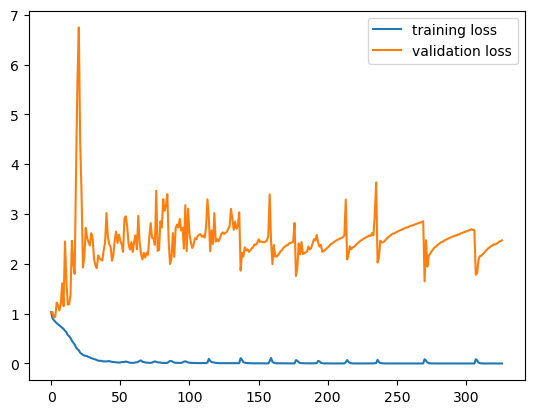

33
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
chromatin


/tmp/ipykernel_1554819/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554819/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0008 loss_val: 1.0891 time: 25.6517s
 Epoch: 0001 loss_train: 0.8663 loss_val: 1.2874 time: 24.9591s
 Epoch: 0002 loss_train: 0.8204 loss_val: 0.8689 time: 24.6606s
 Epoch: 0003 loss_train: 0.7819 loss_val: 1.0271 time: 24.7309s
 Epoch: 0004 loss_train: 0.7517 loss_val: 1.0336 time: 26.7624s
 Epoch: 0005 loss_train: 0.7231 loss_val: 0.7989 time: 25.9226s
 Epoch: 0006 loss_train: 0.6979 loss_val: 0.7809 time: 27.0110s
 Epoch: 0007 loss_train: 0.6734 loss_val: 1.1404 time: 25.9050s
 Epoch: 0008 loss_train: 0.6453 loss_val: 1.3605 time: 25.4989s
 Epoch: 0009 loss_train: 0.6085 loss_val: 1.9768 time: 24.9840s
 Epoch: 0010 loss_train: 0.5764 loss_val: 1.2879 time: 25.9212s
 Epoch: 0011 loss_train: 0.5405 loss_val: 1.6641 time: 23.7502s
 Epoch: 0012 loss_train: 0.4878 loss_val: 1.0735 time: 24.5588s
 Epoch: 0013 loss_train: 0.4522 loss_val: 1.4682 time: 25.3466s
 Epoch: 0014 loss_train: 0.4294 loss_val: 1.3943 time: 24.5483s
 Epoch: 0015 loss_train: 0.3826 loss_val

 Epoch: 0132 loss_train: 0.0262 loss_val: 3.6046 time: 32.4924s
 Epoch: 0133 loss_train: 0.0827 loss_val: 1.9569 time: 30.5512s
 Epoch: 0134 loss_train: 0.0313 loss_val: 2.2991 time: 31.8291s
 Epoch: 0135 loss_train: 0.0156 loss_val: 2.2359 time: 30.7930s
 Epoch: 0136 loss_train: 0.0106 loss_val: 2.1187 time: 32.6115s
 Epoch: 0137 loss_train: 0.0080 loss_val: 2.2986 time: 33.8046s
 Epoch: 0138 loss_train: 0.0049 loss_val: 2.4238 time: 36.3765s
 Epoch: 0139 loss_train: 0.0046 loss_val: 2.3469 time: 32.0824s
 Epoch: 0140 loss_train: 0.0039 loss_val: 2.3602 time: 29.8822s
 Epoch: 0141 loss_train: 0.0033 loss_val: 2.2660 time: 30.0495s
 Epoch: 0142 loss_train: 0.0053 loss_val: 2.2793 time: 29.9110s
 Epoch: 0143 loss_train: 0.0050 loss_val: 2.3010 time: 28.5221s
 Epoch: 0144 loss_train: 0.0039 loss_val: 2.4263 time: 29.1087s
 Epoch: 0145 loss_train: 0.0039 loss_val: 2.3627 time: 30.6622s
 Epoch: 0146 loss_train: 0.0143 loss_val: 2.5382 time: 30.9698s
 Epoch: 0147 loss_train: 0.0413 loss_val

 Epoch: 0261 loss_train: 0.0002 loss_val: 2.3930 time: 27.9921s
 Epoch: 0262 loss_train: 0.0002 loss_val: 2.4390 time: 28.8328s
 Epoch: 0263 loss_train: 0.0009 loss_val: 2.5253 time: 28.5157s
 Epoch: 0264 loss_train: 0.0112 loss_val: 2.8763 time: 26.7393s
 Epoch: 0265 loss_train: 0.0858 loss_val: 2.0174 time: 27.7935s
 Epoch: 0266 loss_train: 0.0248 loss_val: 1.9032 time: 26.8502s
 Epoch: 0267 loss_train: 0.0058 loss_val: 2.0012 time: 28.7944s
 Epoch: 0268 loss_train: 0.0017 loss_val: 2.0520 time: 28.1393s
 Epoch: 0269 loss_train: 0.0006 loss_val: 2.0929 time: 27.7967s
 Epoch: 0270 loss_train: 0.0004 loss_val: 2.1182 time: 27.3470s
 Epoch: 0271 loss_train: 0.0003 loss_val: 2.1500 time: 28.2133s
 Epoch: 0272 loss_train: 0.0003 loss_val: 2.1696 time: 27.4198s
 Epoch: 0273 loss_train: 0.0003 loss_val: 2.1872 time: 27.6004s
 Epoch: 0274 loss_train: 0.0002 loss_val: 2.2044 time: 27.2571s
 Epoch: 0275 loss_train: 0.0002 loss_val: 2.2235 time: 28.7437s
 Epoch: 0276 loss_train: 0.0001 loss_val

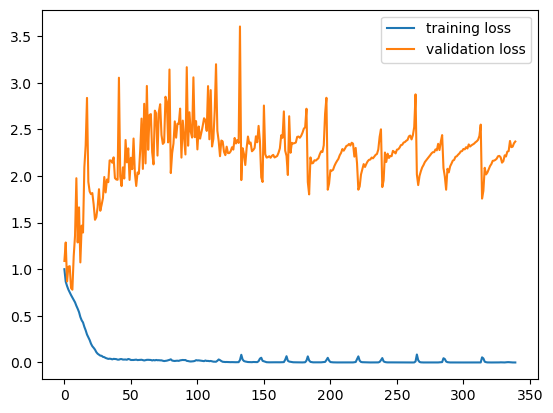

34
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
P57
P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1554819/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554819/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0068 loss_val: 0.9428 time: 27.0462s
 Epoch: 0001 loss_train: 0.8672 loss_val: 1.3742 time: 26.0400s
 Epoch: 0002 loss_train: 0.8283 loss_val: 0.9237 time: 25.8271s
 Epoch: 0003 loss_train: 0.7926 loss_val: 0.9212 time: 26.7331s
 Epoch: 0004 loss_train: 0.7669 loss_val: 0.9169 time: 26.1283s
 Epoch: 0005 loss_train: 0.7383 loss_val: 1.0174 time: 27.0147s
 Epoch: 0006 loss_train: 0.7112 loss_val: 1.0786 time: 27.3916s
 Epoch: 0007 loss_train: 0.6902 loss_val: 0.9460 time: 26.3735s
 Epoch: 0008 loss_train: 0.6661 loss_val: 0.9629 time: 25.8085s
 Epoch: 0009 loss_train: 0.6389 loss_val: 1.0842 time: 25.8799s
 Epoch: 0010 loss_train: 0.6003 loss_val: 1.0930 time: 27.2275s
 Epoch: 0011 loss_train: 0.5630 loss_val: 1.2957 time: 28.1877s
 Epoch: 0012 loss_train: 0.5174 loss_val: 1.2879 time: 25.9615s
 Epoch: 0013 loss_train: 0.4782 loss_val: 1.4124 time: 27.3457s
 Epoch: 0014 loss_train: 0.4215 loss_val: 1.2426 time: 26.3967s
 Epoch: 0015 loss_train: 0.3893 loss_val

 Epoch: 0129 loss_train: 0.0063 loss_val: 2.5469 time: 28.1344s
 Epoch: 0130 loss_train: 0.0056 loss_val: 2.5257 time: 27.6365s
 Epoch: 0131 loss_train: 0.0054 loss_val: 2.4423 time: 27.6233s
 Epoch: 0132 loss_train: 0.0053 loss_val: 2.5277 time: 27.3613s
 Epoch: 0133 loss_train: 0.0045 loss_val: 2.5399 time: 28.0094s
 Epoch: 0134 loss_train: 0.0042 loss_val: 2.5579 time: 27.9603s
 Epoch: 0135 loss_train: 0.0048 loss_val: 2.5438 time: 25.8957s
 Epoch: 0136 loss_train: 0.0049 loss_val: 2.6028 time: 26.8510s
 Epoch: 0137 loss_train: 0.0047 loss_val: 2.6601 time: 27.1256s
 Epoch: 0138 loss_train: 0.0064 loss_val: 2.6908 time: 25.8246s
 Epoch: 0139 loss_train: 0.0089 loss_val: 3.0122 time: 27.5274s
 Epoch: 0140 loss_train: 0.0531 loss_val: 2.3100 time: 26.9678s
 Epoch: 0141 loss_train: 0.0574 loss_val: 2.4242 time: 27.3931s
 Epoch: 0142 loss_train: 0.0221 loss_val: 2.7596 time: 26.8443s
 Epoch: 0143 loss_train: 0.0115 loss_val: 2.4935 time: 27.0845s
 Epoch: 0144 loss_train: 0.0061 loss_val

 Epoch: 0258 loss_train: 0.0025 loss_val: 2.3153 time: 27.5358s
 Epoch: 0259 loss_train: 0.0019 loss_val: 2.3057 time: 27.7128s
 Epoch: 0260 loss_train: 0.0008 loss_val: 2.3664 time: 26.9933s
 Epoch: 0261 loss_train: 0.0007 loss_val: 2.4088 time: 27.6624s
 Epoch: 0262 loss_train: 0.0005 loss_val: 2.4266 time: 27.6965s
 Epoch: 0263 loss_train: 0.0004 loss_val: 2.4630 time: 26.0108s
 Epoch: 0264 loss_train: 0.0004 loss_val: 2.4713 time: 26.3965s
 Epoch: 0265 loss_train: 0.0003 loss_val: 2.5020 time: 26.7354s
 Epoch: 0266 loss_train: 0.0003 loss_val: 2.5380 time: 27.9235s
 Epoch: 0267 loss_train: 0.0006 loss_val: 2.5242 time: 27.1393s
 Epoch: 0268 loss_train: 0.0004 loss_val: 2.5462 time: 27.0644s
 Epoch: 0269 loss_train: 0.0003 loss_val: 2.5617 time: 26.6563s
 Epoch: 0270 loss_train: 0.0004 loss_val: 2.5848 time: 26.9706s
 Epoch: 0271 loss_train: 0.0003 loss_val: 2.5924 time: 26.8215s
 Epoch: 0272 loss_train: 0.0003 loss_val: 2.6048 time: 25.8902s
 Epoch: 0273 loss_train: 0.0003 loss_val

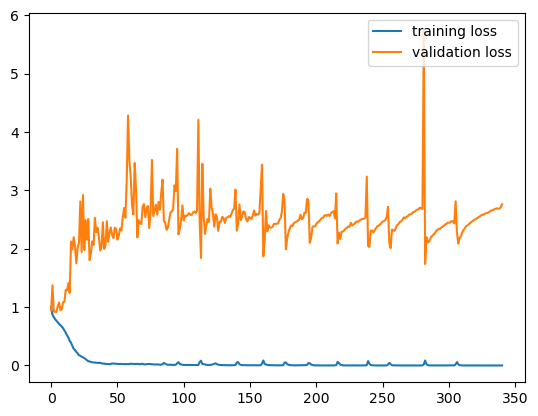

35
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
hold out: P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
hold out: P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1554819/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554819/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0049 loss_val: 1.5150 time: 27.8479s
 Epoch: 0001 loss_train: 0.8835 loss_val: 1.1234 time: 25.7033s
 Epoch: 0002 loss_train: 0.8367 loss_val: 1.0626 time: 26.0664s
 Epoch: 0003 loss_train: 0.8057 loss_val: 1.8495 time: 26.5251s
 Epoch: 0004 loss_train: 0.7901 loss_val: 1.1079 time: 26.6315s
 Epoch: 0005 loss_train: 0.7630 loss_val: 1.0862 time: 25.7154s
 Epoch: 0006 loss_train: 0.7429 loss_val: 1.3748 time: 26.8162s
 Epoch: 0007 loss_train: 0.7141 loss_val: 2.0041 time: 27.7628s
 Epoch: 0008 loss_train: 0.6778 loss_val: 1.1404 time: 27.0691s
 Epoch: 0009 loss_train: 0.6454 loss_val: 1.4268 time: 26.6235s
 Epoch: 0010 loss_train: 0.6201 loss_val: 1.4718 time: 27.0733s
 Epoch: 0011 loss_train: 0.5775 loss_val: 1.2090 time: 26.3868s
 Epoch: 0012 loss_train: 0.5242 loss_val: 1.8596 time: 26.0447s
 Epoch: 0013 loss_train: 0.4886 loss_val: 2.5389 time: 25.7806s
 Epoch: 0014 loss_train: 0.4410 loss_val: 2.7919 time: 26.3773s
 Epoch: 0015 loss_train: 0.4009 loss_val

 Epoch: 0129 loss_train: 0.0825 loss_val: 2.0046 time: 27.4745s
 Epoch: 0130 loss_train: 0.0636 loss_val: 1.8914 time: 27.5464s
 Epoch: 0131 loss_train: 0.0229 loss_val: 2.2206 time: 25.7186s
 Epoch: 0132 loss_train: 0.0158 loss_val: 2.3600 time: 27.3178s
 Epoch: 0133 loss_train: 0.0100 loss_val: 2.1647 time: 27.1669s
 Epoch: 0134 loss_train: 0.0091 loss_val: 2.0374 time: 26.8210s
 Epoch: 0135 loss_train: 0.0047 loss_val: 2.0723 time: 25.9557s
 Epoch: 0136 loss_train: 0.0034 loss_val: 2.1007 time: 27.3725s
 Epoch: 0137 loss_train: 0.0027 loss_val: 2.1087 time: 27.5069s
 Epoch: 0138 loss_train: 0.0031 loss_val: 2.1962 time: 26.5801s
 Epoch: 0139 loss_train: 0.0029 loss_val: 2.2024 time: 26.6198s
 Epoch: 0140 loss_train: 0.0028 loss_val: 2.2281 time: 28.0728s
 Epoch: 0141 loss_train: 0.0030 loss_val: 2.4747 time: 27.1725s
 Epoch: 0142 loss_train: 0.0023 loss_val: 2.2728 time: 25.1952s
 Epoch: 0143 loss_train: 0.0024 loss_val: 2.2820 time: 25.9621s
 Epoch: 0144 loss_train: 0.0019 loss_val

 Epoch: 0258 loss_train: 0.0000 loss_val: 2.8220 time: 26.8072s
 Epoch: 0259 loss_train: 0.0000 loss_val: 2.8279 time: 26.1581s
 Epoch: 0260 loss_train: 0.0000 loss_val: 2.8336 time: 27.3919s
 Epoch: 0261 loss_train: 0.0000 loss_val: 2.8395 time: 25.9758s
 Epoch: 0262 loss_train: 0.0000 loss_val: 2.8453 time: 26.8636s
 Epoch: 0263 loss_train: 0.0000 loss_val: 2.8510 time: 26.6601s
 Epoch: 0264 loss_train: 0.0000 loss_val: 2.8568 time: 25.7715s
 Epoch: 0265 loss_train: 0.0000 loss_val: 2.8627 time: 26.4028s
 Epoch: 0266 loss_train: 0.0000 loss_val: 2.8685 time: 26.4203s
 Epoch: 0267 loss_train: 0.0000 loss_val: 2.8740 time: 27.3357s
 Epoch: 0268 loss_train: 0.0000 loss_val: 2.8799 time: 27.2099s
 Epoch: 0269 loss_train: 0.0000 loss_val: 2.8855 time: 25.7960s
 Epoch: 0270 loss_train: 0.0000 loss_val: 2.8913 time: 27.4006s
 Epoch: 0271 loss_train: 0.0000 loss_val: 2.8969 time: 27.1485s
 Epoch: 0272 loss_train: 0.0000 loss_val: 2.9025 time: 26.2269s
 Epoch: 0273 loss_train: 0.0000 loss_val

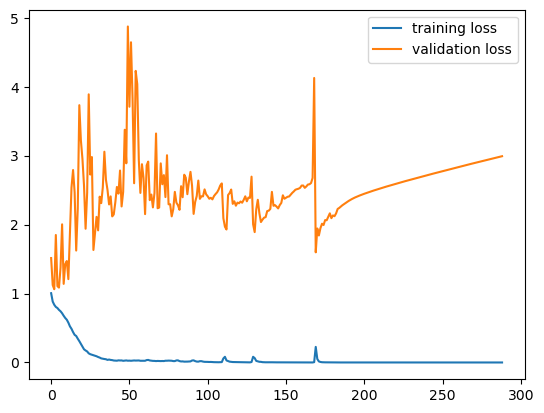

In [10]:
for sample_s in range(prevSampled,nSamples):
    print(sample_s)
    imgsC_all_samples_s=None
    imgsP_all_samples_s=None
    imgNames_all_samples_s=None
    proteinNames_samples_s=None
    pID_all_samples_s=None
    conditions_all_samples_s=None
    
    imgsC_all_val_samples_s={}
    imgsP_all_val_samples_s={}
    imgNames_all_val_samples_s={}
    proteinTrainInput_val_samples_s={}
    pID_all_val_samples_s={}
    conditions_all_val_samples_s={}
    for condition_i in conditions:
        print(condition_i)
        segDir_i=os.path.join(segDir,condition_i)
        imgDir_i=os.path.join(imgDir,condition_i)
        for stain in os.listdir(segDir_i):
            print(stain)
            segDir_i_stain=os.path.join(segDir_i,stain)
            imgDir_i_stain=os.path.join(imgDir_i,stain)

            segPID2name={}
            for pID_dir in os.listdir(segDir_i_stain):
                pID=pID_dir.split('_')
                segPID2name[pID[0]]=pID_dir
            imgPID2name={}
            for pID_dir in os.listdir(imgDir_i_stain):
                pID=pID_dir.split('_')
                imgPID2name[pID[0]]=pID_dir
            for pID in segPID2name.keys():
                if condition_i=='meningioma' and stain=='dapi_gh2ax_lamin_cd3' and pID=='P33': #skipping incorrect images
                    continue
                if pID in holdOutSamples_samples[sample_s%6]:
                    print('hold out: '+pID)
                    continue
                print(pID)
                if pID not in imgPID2name:
                    print('img not found '+pID)
                    continue
                imgDir_i_stain_p=os.path.join(imgDir_i_stain,imgPID2name[pID])
                segDir_i_stain_p=os.path.join(segDir_i_stain,segPID2name[pID])

                with open(os.path.join(imgDir_i_stain_p,savename+'_imgNames'), 'rb') as output:
                    imgNames=pickle.load(output)
                with open(os.path.join(imgDir_i_stain_p,savename+'_img'), 'rb') as output:
                    img=pickle.load(output)

                imgP=np.zeros((img.shape[0],1,img.shape[2],img.shape[3]))
                proteinNames_curr=np.array([])
                stain_list=stain.split('_')
                nImgPerStain=int(img.shape[0]/(len(stain_list)-1))
                np.random.seed(sample_s+6)
                allIdx_all=np.arange(img.shape[0])
                np.random.shuffle(allIdx_all)
                for s in range(1,len(stain_list)):
                    s_start=(s-1)*nImgPerStain
                    if s==len(stain_list)-1:
                        s_end=img.shape[0]
                    else:
                        s_end=s*nImgPerStain
                    imgP[s_start:s_end]=img[allIdx_all[s_start:s_end],s].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                    proteinNames_curr=np.concatenate((proteinNames_curr,np.repeat(stain_list[s],s_end-s_start)))

                    #store other channels for validation
                    for sother in range(1,len(stain_list)):
                        if sother==s:
                            continue
                        if stain_list[sother] not in imgsP_all_val_samples_s.keys():
                            proteinTrainInput_val_samples_s[stain_list[sother]]=np.repeat(stain_list[s],s_end-s_start)
                            pID_all_val_samples_s[stain_list[sother]]=np.repeat(pID,s_end-s_start)
                            imgsC_all_val_samples_s[stain_list[sother]]=img[allIdx_all[s_start:s_end],0].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                            imgNames_all_val_samples_s[stain_list[sother]]=imgNames[allIdx_all[s_start:s_end]]
                            imgsP_all_val_samples_s[stain_list[sother]]=img[allIdx_all[s_start:s_end],sother].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                            conditions_all_val_samples_s[stain_list[sother]]=np.repeat(condition_i,s_end-s_start)
                        else:
                            proteinTrainInput_val_samples_s[stain_list[sother]]=np.concatenate((proteinTrainInput_val_samples_s[stain_list[sother]],np.repeat(stain_list[s],s_end-s_start)))
                            pID_all_val_samples_s[stain_list[sother]]=np.concatenate((pID_all_val_samples_s[stain_list[sother]],np.repeat(pID,s_end-s_start)))
                            imgsC_all_val_samples_s[stain_list[sother]]=np.concatenate((imgsC_all_val_samples_s[stain_list[sother]],img[allIdx_all[s_start:s_end],0].reshape(s_end-s_start,1,img.shape[2],img.shape[3])),axis=0)
                            imgNames_all_val_samples_s[stain_list[sother]]=np.concatenate((imgNames_all_val_samples_s[stain_list[sother]],imgNames[allIdx_all[s_start:s_end]]))
                            imgsP_all_val_samples_s[stain_list[sother]]=np.concatenate((imgsP_all_val_samples_s[stain_list[sother]],img[allIdx_all[s_start:s_end],sother].reshape(s_end-s_start,1,img.shape[2],img.shape[3])),axis=0)
                            conditions_all_val_samples_s[stain_list[sother]]=np.concatenate((conditions_all_val_samples_s[stain_list[sother]],np.repeat(condition_i,s_end-s_start)))
                if pID_all_samples_s is None:
                    pID_all_samples_s=np.repeat(pID,img.shape[0])
                    imgsC_all_samples_s=img[allIdx_all,[0]]
                    imgNames_all_samples_s=imgNames[allIdx_all]
                    proteinNames_samples_s=proteinNames_curr
                    imgsP_all_samples_s=imgP
                    conditions_all_samples_s=np.repeat(condition_i,img.shape[0])
                else:
                    pID_all_samples_s=np.concatenate((pID_all_samples_s,np.repeat(pID,img.shape[0])))
                    imgsC_all_samples_s=np.concatenate((imgsC_all_samples_s,img[allIdx_all,[0]]),axis=0)
                    imgNames_all_samples_s=np.concatenate((imgNames_all_samples_s,imgNames[allIdx_all]))
                    proteinNames_samples_s=np.concatenate((proteinNames_samples_s,proteinNames_curr))
                    imgsP_all_samples_s=np.concatenate((imgsP_all_samples_s,imgP),axis=0)
                    conditions_all_samples_s=np.concatenate((conditions_all_samples_s,np.repeat(condition_i,img.shape[0])))
    imgsC_all_samples_s=imgsC_all_samples_s.reshape(imgsC_all_samples_s.shape[0],1,imgsC_all_samples_s.shape[1],imgsC_all_samples_s.shape[2])

    p_curr='chromatin'
    starget_index=0 #randomly selected protein ID for all chromatin images regardless of LO training ID

    print(p_curr)


    np.random.seed(sample_s+6)
    pctVal=0.1

    allIdx=np.arange(conditions_all_samples_s.size)
    np.random.shuffle(allIdx)
    valIdx=allIdx[:int(pctVal*allIdx.size)]
    trainIdx=allIdx[int(pctVal*allIdx.size):]

    logsavepath_train_curr=os.path.join(logsavepath_train,p_curr)
    modelsavepath_train_curr=os.path.join(modelsavepath_train,p_curr)
    plotsavepath_train_curr=os.path.join(plotsavepath_train,p_curr)
    if not os.path.exists(logsavepath_train_curr):
        os.mkdir(logsavepath_train_curr)
    if not os.path.exists(modelsavepath_train_curr):
        os.mkdir(modelsavepath_train_curr)
    if not os.path.exists(plotsavepath_train_curr):
        os.mkdir(plotsavepath_train_curr)
    logsavepath_train_curr=os.path.join(logsavepath_train,p_curr,str(sample_s+6))
    modelsavepath_train_curr=os.path.join(modelsavepath_train,p_curr,str(sample_s+6))
    plotsavepath_train_curr=os.path.join(plotsavepath_train,p_curr,str(sample_s+6))
    if not os.path.exists(logsavepath_train_curr):
        os.mkdir(logsavepath_train_curr)
    if not os.path.exists(modelsavepath_train_curr):
        os.mkdir(modelsavepath_train_curr)
    if not os.path.exists(plotsavepath_train_curr):
        os.mkdir(plotsavepath_train_curr)

    cnames,revIdx_c,cCounts=np.unique(conditions_all_samples_s[trainIdx],return_inverse=True,return_counts=True)
    clfWeight=1/cCounts
    clfWeight=clfWeight/np.sum(clfWeight)
    loss_clf=torch.nn.CrossEntropyLoss(weight=torch.tensor(clfWeight).cuda().float())
    cnames_val,revIdx_c_val,cCounts_val=np.unique(conditions_all_samples_s[valIdx],return_inverse=True,return_counts=True)

    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = True
    if modelname_train=='resnet18':
        model=torchvision.models.resnet18(num_classes=cnames.size)
        model.conv1=torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) #change to one input channel
    elif modelname_train=='alexnet':
        model=torchvision.models.alexnet(num_classes=cnames.size)
        model.features[0]=torch.nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    elif modelname_train=='cnn_base':
        model=model_clf.cnn_clf.CNN_VAE_clf(4, 2, 1, 1, 64,128,256,256,96, 96*4*4,64,cnames.size)
    model.cuda()
    optimizer_clf = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    #c2c - train samples
    plabels=torch.tensor(np.repeat(starget_index,trainIdx.size)).long()
    c2c_res_train=np.zeros_like(imgsC_all_samples_s[trainIdx])
    with torch.no_grad():
        nvalBatches=int(np.ceil(trainIdx.shape[0]/batchsize))
        for i in range(nvalBatches):
            valIdx_i=trainIdx[i*batchsize:min((i+1)*batchsize,trainIdx.shape[0])]
            valtarget_dna=torch.tensor(imgsC_all_samples_s[valIdx_i]).cuda().float()
            valInput_ID=plabels[i*batchsize:min((i+1)*batchsize,trainIdx.shape[0])].cuda()
            valIdx_i=torch.tensor(valIdx_i)

            reconShared_dna_l,recon_dna_l= modelcnn_dna(valtarget_dna,valInput_ID)

            recon_dna=modelcnn_dna_dec(torch.cat((reconShared_dna_l,recon_dna_l),dim=1),pIDemb_dec(valInput_ID))
            c2c_res_train[i*batchsize:min((i+1)*batchsize,trainIdx.shape[0])]=recon_dna.cpu().numpy()

    #c2c - validation samples
    plabels=torch.tensor(np.repeat(starget_index,valIdx.size)).long()
    c2c_res=np.zeros_like(imgsC_all_samples_s[valIdx])
    with torch.no_grad():
        nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
        for i in range(nvalBatches):
            valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
            valtarget_dna=torch.tensor(imgsC_all_samples_s[valIdx_i]).cuda().float()
            valInput_ID=plabels[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])].cuda()
            valIdx_i=torch.tensor(valIdx_i)

            reconShared_dna_l,recon_dna_l= modelcnn_dna(valtarget_dna,valInput_ID)

            recon_dna=modelcnn_dna_dec(torch.cat((reconShared_dna_l,recon_dna_l),dim=1),pIDemb_dec(valInput_ID))
            c2c_res[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]=recon_dna.cpu().numpy()

    #train classifier
    train_loss=[np.inf]*epochs
    val_loss=[np.inf]*epochs

    t_ep=time.time()

    epCounts=0
    for ep in range(epochs):
        train_loss[ep],val_loss[ep]=train(ep,model,optimizer_clf,c2c_res_train,c2c_res,torch.tensor(revIdx_c),torch.tensor(revIdx_c_val))

        if ep>50 and val_loss[ep]>=val_loss[ep-50]:
            epCounts+=1

        if epCounts>150:
            break


        if ep%saveFreq == (saveFreq-1):
            torch.save(model.cpu().state_dict(), os.path.join(modelsavepath_train_curr,'ep'+str(ep)+'.pt'))


        model.cuda()
        torch.cuda.empty_cache()
    print(' total time: {:.4f}s'.format(time.time() - t_ep))


    with open(os.path.join(logsavepath_train_curr,'train_loss'), 'wb') as output:
        pickle.dump(train_loss, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath_train_curr,'val_loss'), 'wb') as output:
        pickle.dump(val_loss, output, pickle.HIGHEST_PROTOCOL)


    plt.plot(np.arange(epochs),train_loss)
    plt.plot(np.arange(epochs),val_loss)
    plt.legend(['training loss','validation loss'],loc='upper right')
    plt.savefig(os.path.join(plotsavepath_train_curr,'loss_seed3.jpg'))
    plt.show()



In [11]:
def plotCTcomp(labels,ctlist,savepath,savenamecluster,byCT,addname='',ctorder=None,vmin=None,vmax=None):
    if ctorder is None:
        ctorder=np.unique(ctlist)
    res=np.zeros((np.unique(labels).size,ctorder.size))
    for li in range(res.shape[0]):
        l=np.unique(labels)[li]
        nl=np.sum(labels==l)
        ctlist_l=ctlist[labels==l]
        for ci in range(res.shape[1]):
            c=ctorder[ci]
            res[li,ci]=np.sum(ctlist_l==c)
#             res[li,ci]=np.sum(ctlist_l==c)/nl
    if not byCT:
        addname+=''
        for li in range(res.shape[0]):
            l=np.unique(labels)[li]
            nl=np.sum(labels==l)
            res[li]=res[li]/nl
    else:
        addname+='_normbyCT'
        for ci in range(res.shape[1]):
            c=ctorder[ci]
            nc=np.sum(ctlist==c)
            res[:,ci]=res[:,ci]/nc
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(res,cmap='binary',vmin=vmin,vmax=vmax)
    ax.set_yticks(np.arange(np.unique(labels).size))
    ax.set_yticklabels(np.unique(labels))
    ax.set_xticks(np.arange(ctorder.size))
    ax.set_xticklabels(ctorder)
    resplot=np.around(res,3)
    for i in range(resplot.shape[0]):
        for j in range(resplot.shape[1]):
            text = ax.text(j, i, resplot[i, j],
                           ha="center", va="center", color="r")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fig.colorbar(im)
    fig.tight_layout()
    plt.savefig(os.path.join(savepath,savenamecluster+addname+'.pdf'))
    plt.close()
    return res

In [12]:
p_curr='chromatin'
res_val=np.zeros((nSamples,cnames.size,cnames.size))
res_heldout=np.zeros((nSamples,cnames.size,cnames.size))
correctCount_val=[None]*nSamples
correctCount_heldout=[None]*nSamples

print(p_curr)

for sample_s in range(nSamples):
    imgsC_all_samples_s=None
    imgsP_all_samples_s=None
    imgNames_all_samples_s=None
    proteinNames_samples_s=None
    pID_all_samples_s=None
    conditions_all_samples_s=None
    
    imgsC_all_val_samples_s={}
    imgsP_all_val_samples_s={}
    imgNames_all_val_samples_s={}
    proteinTrainInput_val_samples_s={}
    pID_all_val_samples_s={}
    conditions_all_val_samples_s={}
    for condition_i in conditions:
        print(condition_i)
        segDir_i=os.path.join(segDir,condition_i)
        imgDir_i=os.path.join(imgDir,condition_i)
        for stain in os.listdir(segDir_i):
            print(stain)
            segDir_i_stain=os.path.join(segDir_i,stain)
            imgDir_i_stain=os.path.join(imgDir_i,stain)

            segPID2name={}
            for pID_dir in os.listdir(segDir_i_stain):
                pID=pID_dir.split('_')
                segPID2name[pID[0]]=pID_dir
            imgPID2name={}
            for pID_dir in os.listdir(imgDir_i_stain):
                pID=pID_dir.split('_')
                imgPID2name[pID[0]]=pID_dir
            for pID in segPID2name.keys():
                if condition_i=='meningioma' and stain=='dapi_gh2ax_lamin_cd3' and pID=='P33': #skipping incorrect images
                    continue
                if pID in holdOutSamples_samples[sample_s%6]:
                    print('hold out: '+pID)
                    continue
                print(pID)
                if pID not in imgPID2name:
                    print('img not found '+pID)
                    continue
                imgDir_i_stain_p=os.path.join(imgDir_i_stain,imgPID2name[pID])
                segDir_i_stain_p=os.path.join(segDir_i_stain,segPID2name[pID])

                with open(os.path.join(imgDir_i_stain_p,savename+'_imgNames'), 'rb') as output:
                    imgNames=pickle.load(output)
                with open(os.path.join(imgDir_i_stain_p,savename+'_img'), 'rb') as output:
                    img=pickle.load(output)

                imgP=np.zeros((img.shape[0],1,img.shape[2],img.shape[3]))
                proteinNames_curr=np.array([])
                stain_list=stain.split('_')
                nImgPerStain=int(img.shape[0]/(len(stain_list)-1))
                np.random.seed(sample_s+6)
                allIdx_all=np.arange(img.shape[0])
                np.random.shuffle(allIdx_all)
                for s in range(1,len(stain_list)):
                    s_start=(s-1)*nImgPerStain
                    if s==len(stain_list)-1:
                        s_end=img.shape[0]
                    else:
                        s_end=s*nImgPerStain
                    imgP[s_start:s_end]=img[allIdx_all[s_start:s_end],s].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                    proteinNames_curr=np.concatenate((proteinNames_curr,np.repeat(stain_list[s],s_end-s_start)))

                    #store other channels for validation
                    for sother in range(1,len(stain_list)):
                        if sother==s:
                            continue
                        if stain_list[sother] not in imgsP_all_val_samples_s.keys():
                            proteinTrainInput_val_samples_s[stain_list[sother]]=np.repeat(stain_list[s],s_end-s_start)
                            pID_all_val_samples_s[stain_list[sother]]=np.repeat(pID,s_end-s_start)
                            imgsC_all_val_samples_s[stain_list[sother]]=img[allIdx_all[s_start:s_end],0].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                            imgNames_all_val_samples_s[stain_list[sother]]=imgNames[allIdx_all[s_start:s_end]]
                            imgsP_all_val_samples_s[stain_list[sother]]=img[allIdx_all[s_start:s_end],sother].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                            conditions_all_val_samples_s[stain_list[sother]]=np.repeat(condition_i,s_end-s_start)
                        else:
                            proteinTrainInput_val_samples_s[stain_list[sother]]=np.concatenate((proteinTrainInput_val_samples_s[stain_list[sother]],np.repeat(stain_list[s],s_end-s_start)))
                            pID_all_val_samples_s[stain_list[sother]]=np.concatenate((pID_all_val_samples_s[stain_list[sother]],np.repeat(pID,s_end-s_start)))
                            imgsC_all_val_samples_s[stain_list[sother]]=np.concatenate((imgsC_all_val_samples_s[stain_list[sother]],img[allIdx_all[s_start:s_end],0].reshape(s_end-s_start,1,img.shape[2],img.shape[3])),axis=0)
                            imgNames_all_val_samples_s[stain_list[sother]]=np.concatenate((imgNames_all_val_samples_s[stain_list[sother]],imgNames[allIdx_all[s_start:s_end]]))
                            imgsP_all_val_samples_s[stain_list[sother]]=np.concatenate((imgsP_all_val_samples_s[stain_list[sother]],img[allIdx_all[s_start:s_end],sother].reshape(s_end-s_start,1,img.shape[2],img.shape[3])),axis=0)
                            conditions_all_val_samples_s[stain_list[sother]]=np.concatenate((conditions_all_val_samples_s[stain_list[sother]],np.repeat(condition_i,s_end-s_start)))
                if pID_all_samples_s is None:
                    pID_all_samples_s=np.repeat(pID,img.shape[0])
                    imgsC_all_samples_s=img[allIdx_all,[0]]
                    imgNames_all_samples_s=imgNames[allIdx_all]
                    proteinNames_samples_s=proteinNames_curr
                    imgsP_all_samples_s=imgP
                    conditions_all_samples_s=np.repeat(condition_i,img.shape[0])
                else:
                    pID_all_samples_s=np.concatenate((pID_all_samples_s,np.repeat(pID,img.shape[0])))
                    imgsC_all_samples_s=np.concatenate((imgsC_all_samples_s,img[allIdx_all,[0]]),axis=0)
                    imgNames_all_samples_s=np.concatenate((imgNames_all_samples_s,imgNames[allIdx_all]))
                    proteinNames_samples_s=np.concatenate((proteinNames_samples_s,proteinNames_curr))
                    imgsP_all_samples_s=np.concatenate((imgsP_all_samples_s,imgP),axis=0)
                    conditions_all_samples_s=np.concatenate((conditions_all_samples_s,np.repeat(condition_i,img.shape[0])))
    imgsC_all_samples_s=imgsC_all_samples_s.reshape(imgsC_all_samples_s.shape[0],1,imgsC_all_samples_s.shape[1],imgsC_all_samples_s.shape[2])

    p_curr='chromatin'
    starget_index=0 #randomly selected protein ID for all chromatin images regardless of LO training ID

    print(p_curr)


    np.random.seed(sample_s+6)
    pctVal=0.1

    allIdx=np.arange(conditions_all_samples_s.size)
    np.random.shuffle(allIdx)
    valIdx=allIdx[:int(pctVal*allIdx.size)]
    trainIdx=allIdx[int(pctVal*allIdx.size):]

    plotsavepath_train_p=os.path.join(plotsavepath_train,p_curr)

    logsavepath_train_curr=os.path.join(logsavepath_train,p_curr,str(sample_s+6))
    modelsavepath_train_curr=os.path.join(modelsavepath_train,p_curr,str(sample_s+6))
    plotsavepath_train_curr=os.path.join(plotsavepath_train,p_curr,str(sample_s+6))

    cnames,revIdx_c,cCounts=np.unique(conditions_all_samples_s[trainIdx],return_inverse=True,return_counts=True)
    clfWeight=1/cCounts
    clfWeight=clfWeight/np.sum(clfWeight)
    loss_clf=torch.nn.CrossEntropyLoss(weight=torch.tensor(clfWeight).cuda().float())
    cnames_val,revIdx_c_val,cCounts_val=np.unique(conditions_all_samples_s[valIdx],return_inverse=True,return_counts=True)

    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = True
    if modelname_train=='resnet18':
        model=torchvision.models.resnet18(num_classes=cnames.size)
        model.conv1=torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) #change to one input channel
    elif modelname_train=='alexnet':
        model=torchvision.models.alexnet(num_classes=cnames.size)
        model.features[0]=torch.nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    elif modelname_train=='cnn_base':
        model=model_clf.cnn_clf.CNN_VAE_clf(4, 2, 1, 1, 64,128,256,256,96, 96*4*4,64,cnames.size)
    model.cuda()

    with open(os.path.join(logsavepath_train_curr,'val_loss'), 'rb') as output:
        val_loss=pickle.load(output)
    minlossepoch=np.argmin(val_loss)
    minlossepoch_saved=int(np.round(minlossepoch/saveFreq)*saveFreq)-1
    if minlossepoch_saved==-1:
        minlossepoch_saved=saveFreq-1
    if val_loss[minlossepoch_saved-saveFreq]<val_loss[minlossepoch_saved]:
        if val_loss[minlossepoch_saved+saveFreq]<val_loss[minlossepoch_saved-saveFreq]:
            minlossepoch_saved=minlossepoch_saved+saveFreq
        else:
            minlossepoch_saved=minlossepoch_saved-saveFreq
    if minlossepoch_saved==-1:
        minlossepoch_saved=saveFreq-1
    model.load_state_dict(torch.load(os.path.join(modelsavepath_train_curr,'ep'+str(minlossepoch_saved)+'.pt')))

    #c2c - validation samples
    plabels=torch.tensor(np.repeat(starget_index,valIdx.size)).long()
    c2c_res=np.zeros_like(imgsC_all_samples_s[valIdx])
    with torch.no_grad():
        nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
        for i in range(nvalBatches):
            valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
            valtarget_dna=torch.tensor(imgsC_all_samples_s[valIdx_i]).cuda().float()
            valInput_ID=plabels[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])].cuda()
            valIdx_i=torch.tensor(valIdx_i)

            reconShared_dna_l,recon_dna_l= modelcnn_dna(valtarget_dna,valInput_ID)

            recon_dna=modelcnn_dna_dec(torch.cat((reconShared_dna_l,recon_dna_l),dim=1),pIDemb_dec(valInput_ID))
            c2c_res[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]=recon_dna.cpu().numpy()
    
    #validation samples
    with torch.no_grad():
        model.eval()
        loss_val_all=0
        nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
        pred_curr=np.array([])
        for i in range(nvalBatches):
            valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
            val_labels=torch.tensor(revIdx_c_val[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]).cuda().long()
            valInput=torch.tensor(c2c_res[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]).cuda().float()


            pred = model(valInput)

            loss=loss_clf(pred, val_labels)
            loss_val_all+=loss.item()
            pred_curr=np.concatenate((pred_curr,np.argmax(pred.detach().cpu().numpy(),axis=1)))

        loss_val_all=loss_val_all/nvalBatches

    print('loss_val: {:.4f}'.format(loss_val_all))
    correctCount=np.sum(pred_curr==revIdx_c_val)/pred_curr.size
    print('acc: {:.4f}'.format(correctCount))

    pred_curr=pred_curr.astype(int)
    res_val[sample_s]=plotCTcomp(cnames[revIdx_c_val],cnames[pred_curr],plotsavepath_train_curr,'confusion_val_moreSamples',False,addname='',ctorder=None,vmin=0,vmax=1)
    correctCount_val[sample_s]=correctCount
    with open(os.path.join(plotsavepath_train_curr,'pred_val_moreSamples'), 'wb') as output:
        pickle.dump(pred_curr, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(plotsavepath_train_curr,'true_val_moreSamples'), 'wb') as output:
        pickle.dump(revIdx_c_val, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(plotsavepath_train_curr,'true_cnames_moreSamples'), 'wb') as output:
        pickle.dump(cnames, output, pickle.HIGHEST_PROTOCOL)

    
with open(os.path.join(plotsavepath_train_p,'acc_val_moreSamples'), 'wb') as output:
    pickle.dump(correctCount_val, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(plotsavepath_train_p,'confusion_val_moreSamples'), 'wb') as output:
    pickle.dump(res_val, output, pickle.HIGHEST_PROTOCOL)




chromatin
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
chromatin
loss_val: 2.1773
acc: 0.6839
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dap

HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
chromatin
loss_val: 2.4716
acc: 0.6915
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83

HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
chromatin
loss_val: 2.8510
acc: 0.6245
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
gl

In [13]:
print('avg val acc: {:.4f}'.format(np.mean(correctCount_val)))
# print('avg held out acc: {:.4f}\n'.format(np.mean(correctCount_heldout)))

avg val acc: 0.6545
